<div style="text-align: center;">
    <h1>RNN - Series Temporales</h1>
</div>

## Índice

- [1 - Preparación de Datos](#preparaciondedatos)
- [1.1 - Carga de Datos](#cargadedatos)
- [1.2 - Limpieza de Datos](#limpiezadedatos)
- [1.3 - Transformación de Datos](#transformaciondedatos)
- [2 - Exploración de los Datos](#exploraciondedatos)
- [3 - Modelado](#modelado)

<div id="objetivo" style="text-align: left;">
    <h4>Objetivo</h4>
</div>

El objetivo de este trabajo es predecir las ventas futuras utilizando una RNN (Recurrent Neural Network).

Los datos que se utilizaron en este proyecto fueron obtenidos de la plataforma Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview).



Los datos corresponden a transacciones realizadas entre octubre del 2018 y octubre del 2020.

<div style="text-align: left;">
    <h4>Instalación de Librerias</h4>
</div>

<div style="text-align: left;">
    <h4>Carga de Librerias</h4>
</div>

<div id="preparaciondedatos" style="text-align: center;">
    <h2><u>Preparación de Datos</u></h2>
</div>

In [7]:
import random
import warnings
from datetime import datetime
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_percentage_error, pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Configuración
warnings.filterwarnings("ignore")
random_seed = 54
np.random.seed(random_seed)
random.seed(random_seed)


<div style="text-align: left;">
    <h4>Carga de Funciones</h4>
</div>

In [2]:
# Se define función que cuenta la cantidad de valores nulos en cada columna de un DataFrame y se calcula
# el porcentaje de valores nulos por columna.

def contar_valores_nulos_con_porcentaje(dataframe):

    nulos_por_columna = dataframe.isnull().sum()
    porcentaje_nulos_por_columna = (nulos_por_columna / len(dataframe)) * 100

    resultados = pd.DataFrame({
        'Cantidad de Nulos': nulos_por_columna,
        'Porcentaje de Nulos (%)': porcentaje_nulos_por_columna
    })

    return resultados

#Se define función que elimina los valores atípicos de una columna específica en un DataFrame.
#La misma utiliza el método de rango intercuartílico para identificar valores atípicos, que son aquellos puntos de datos
#que caen fuera del rango definido por el primer cuartil (Q1) y el tercer cuartil (Q3).

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

#Se define función que elimina iterativamente los valores atípicos de una columna específica en un DataFrame hasta que
#no se encuentren más valores atípicos según el criterio del rango intercuartílico definido en la función "remove_outliers".

def remove_outliers_iteratively(df, column_name):
    df_clean = df.copy()
    while True:
        initial_len = len(df_clean)
        df_clean = remove_outliers(df_clean, column_name)
        final_len = len(df_clean)
        if initial_len == final_len:
            break
    return df_clean

In [3]:
def count_outliers(df, column):
    """
    Cuenta el número de valores atípicos en una columna específica de un DataFrame.

    Args:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna en la que se contarán los valores atípicos.

    Returns:
    int: El número de valores atípicos en la columna especificada.
    """
    # Calcular Q1 (primer cuartil), Q3 (tercer cuartil) y el IQR (rango intercuartílico)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los valores atípicos
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]

    return num_outliers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
articles = pd.read_csv("/content/drive/MyDrive/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/customers.csv")

In [8]:
# Especifica el nombre del archivo ZIP
zip_file = '/content/drive/MyDrive/transactions_train.csv.zip'

# Abre el archivo ZIP y lee el CSV
with zipfile.ZipFile(zip_file, 'r') as z:
    # Lista de archivos dentro del ZIP
    file_list = z.namelist()
    # Asumimos que hay solo un archivo CSV dentro del ZIP
    csv_file = file_list[0]
    # Lee el archivo CSV en un DataFrame
    transactions = pd.read_csv(z.open(csv_file))

<h5><u>Transactions</u></h5>

In [9]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [10]:
transactions.shape

(31788324, 5)

In [11]:
transactions.dtypes

,0
t_dat,object
customer_id,object
article_id,int64
price,float64
sales_channel_id,int64


<h5><u>Articles</u></h5>

In [12]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [13]:
articles.shape

(105542, 25)

In [14]:
articles.dtypes

,0
article_id,int64
product_code,int64
prod_name,object
product_type_no,int64
product_type_name,object
product_group_name,object
graphical_appearance_no,int64
graphical_appearance_name,object
colour_group_code,int64
colour_group_name,object


<h5><u>Customers</u></h5>

In [15]:
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [16]:
customers.shape

(1371980, 7)

In [17]:
customers.dtypes

,0
customer_id,object
FN,float64
Active,float64
club_member_status,object
fashion_news_frequency,object
age,float64
postal_code,object


<div id="limpiezadedatos" style="text-align: center;">
    <h3><u>Limpieza de Datos</u></h3>
</div>

In [18]:
contar_valores_nulos_con_porcentaje(transactions)

,Cantidad de Nulos,Porcentaje de Nulos (%)
t_dat,0,0.0
customer_id,0,0.0
article_id,0,0.0
price,0,0.0
sales_channel_id,0,0.0


In [19]:
transactions.dtypes

,0
t_dat,object
customer_id,object
article_id,int64
price,float64
sales_channel_id,int64


In [20]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [21]:
# Extraer año y mes de la columna de fecha
transactions['year'] = transactions['t_dat'].dt.year
transactions['month'] = transactions['t_dat'].dt.month

# Función para muestrear el 30% de cada grupo
def sample_group(group):
    return group.sample(frac=0.03)

# Aplicar la función de muestreo a cada grupo (por año y mes)
sampled_transactions = transactions.groupby(['year', 'month']).apply(sample_group).reset_index(drop=True)

# Eliminar las columnas 'year' y 'month' para mantener las mismas columnas originales
sampled_transactions = sampled_transactions.drop(columns=['year', 'month'])


In [22]:
transactions = sampled_transactions

In [23]:
contar_valores_nulos_con_porcentaje(customers)

,Cantidad de Nulos,Porcentaje de Nulos (%)
customer_id,0,0.000000
FN,895050,65.237831
Active,907576,66.150819
club_member_status,6062,0.441843
fashion_news_frequency,16011,1.167000
age,15861,1.156066
postal_code,0,0.000000


In [24]:
contar_valores_nulos_con_porcentaje(articles)

,Cantidad de Nulos,Porcentaje de Nulos (%)
article_id,0,0.000000
product_code,0,0.000000
prod_name,0,0.000000
product_type_no,0,0.000000
product_type_name,0,0.000000
product_group_name,0,0.000000
graphical_appearance_no,0,0.000000
graphical_appearance_name,0,0.000000
colour_group_code,0,0.000000
colour_group_name,0,0.000000


<h6><u>Price</u></h6>

Se analiza la distribución de los precios en el dataset de transacciones visualizandose outliers.

<Axes: ylabel='price'>

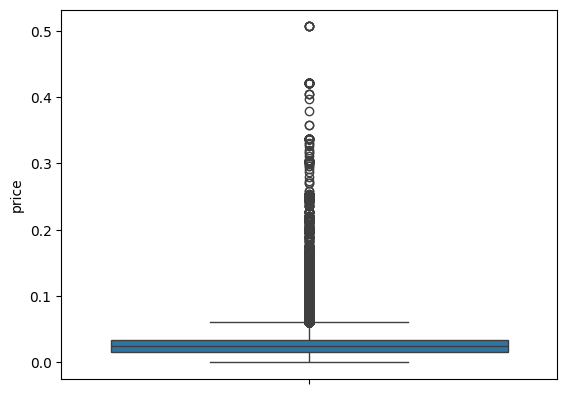

In [25]:
sns.boxplot(y = transactions['price'])

<Axes: xlabel='price', ylabel='Count'>

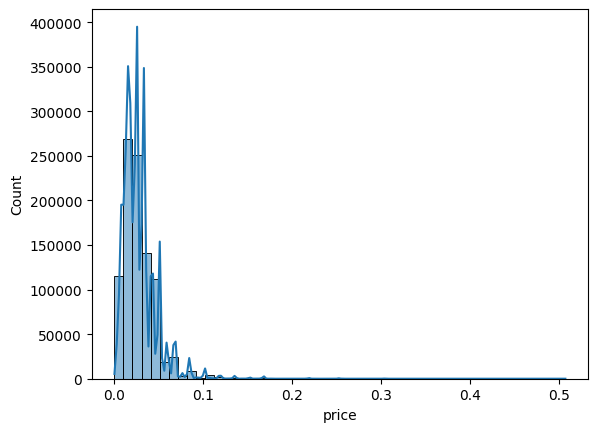

In [26]:
sns.histplot(data=transactions, x="price", palette='winter', bins=50, kde=True)

Se visualizan 47.414 outliers. Dado el objetivo a resolver, se decide no eliminar los valores atípicos.

In [27]:
# Cuenta la cantidad de outliers que tiene la variable price
count_outliers(transactions, 'price')

47414

In [28]:
#transactions = remove_outliers_iteratively(transactions, 'price')

<div id="transformaciondedatos" style="text-align: center;">
    <h3><u>Transformación de Datos</u></h3>
</div>

In [29]:
# Calcular el Precio Promedio y Máximo de cada Producto
preciopart = transactions.groupby('article_id', as_index=False).agg(
    Precio_Prom=('price', 'mean'),
    Min_Precio=('price', min),
    Max_Precio=('price', max))

# Unir esta información con la tabla de transacciones
transactions = transactions.merge(preciopart, on='article_id', how='left')

# Calcular el descuento en cada transacción
transactions['discount_amount'] = transactions['Max_Precio'] - transactions['price']
transactions['discount_percent'] = (transactions['discount_amount'] / transactions['Max_Precio']) * 100

# Añadir una columna para indicar si es una venta con descuento
transactions['sale_type'] = transactions.apply(
    lambda row: 'Venta con Descuento' if row['discount_amount'] > 0 else 'Venta Común', axis=1)

transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,Precio_Prom,Min_Precio,Max_Precio,discount_amount,discount_percent,sale_type
0,2018-09-29,3122962e3dc0b18aea569074dd9eb75818777b2f410ef4...,594430007,0.016932,2,0.016932,0.016932,0.016932,0.000000,0.000000,Venta Común
1,2018-09-28,5d5b2f8255615c2cd95d5aae83b549b72a08ad73562ea2...,636935009,0.040661,1,0.046051,0.027441,0.050831,0.010169,20.006669,Venta con Descuento
2,2018-09-23,82b70a7a3a82f176d3db01c1001d084d84cc9ed58a14b7...,456163028,0.033881,2,0.032199,0.027102,0.033881,0.000000,0.000000,Venta Común
3,2018-09-21,b9fab136cef4953dee0aeabea6c43c8e504b0195b770d6...,610730027,0.020322,2,0.020322,0.020322,0.020322,0.000000,0.000000,Venta Común
4,2018-09-29,6fd6552543ff938152719fb99af276334fb3a55f61614a...,685079002,0.025407,2,0.021593,0.015237,0.025407,0.000000,0.000000,Venta Común


A continuación, se crea una nueva columna con número de transacción (fecha y número de cliente) con el objetivo de analizar la cantidad de artículos comprados por transacción a efectos de analizar posibles fraudes o errores en la información.

In [30]:
# Convertir fechas
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Crear una nueva columna concatenando la fecha y el ID del cliente como string
transactions['n_trans'] = transactions['t_dat'].astype(str) + '_' + transactions['customer_id']

# Agrupar por la nueva columna y contar la cantidad de artículos por transacción
trans_dia = transactions.groupby('n_trans', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by='Cantidad', ascending=False)

In [31]:
ventas_dto = transactions.groupby(['customer_id','sale_type'], as_index=False).agg(Cantidad=('article_id', 'count'))

In [32]:
ventas_dto = pd.pivot_table(ventas_dto, values='Cantidad', index='customer_id', columns=['sale_type'], fill_value=0)

<h6><u>Ventas por Store</u></h6>

In [36]:
# Con este codigo, se visualizan la cantidad de ventas por tienda, Store y Online
store = transactions.groupby(['customer_id','sales_channel_id'], as_index=False).agg(Cantidad=('article_id', 'count'))
store = pd.pivot_table(store, values='Cantidad', index='customer_id', columns=['sales_channel_id'], fill_value=0)

<h6><u>Ventas por Customer_Id</u></h6>

In [37]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('n_trans', 'nunique'),
    antiguedad=("t_dat", lambda x: (max(x) - min(x)).days)
)

<div id="exploraciondedatos" style="text-align: center;">
    <h2><u>Exploración de Datos</u></h2>
</div>

<h6><u>Frecuencia de Compra</u></h6>

In [38]:
# Ordenar las transacciones por customer_id y fecha
transactions = transactions.sort_values(by=['customer_id', 't_dat'])

# Calcular la visita anterior para cada transacción
transactions['previous_visit'] = transactions.groupby('customer_id')['t_dat'].shift()

# Calcular los días entre visitas
transactions['days_bw_visits'] = (transactions['t_dat'] - transactions['previous_visit']).dt.days

# Calcular el promedio de días entre compras para cada cliente
promedio_dias_compra = transactions.groupby('customer_id')['days_bw_visits'].mean().reset_index()
promedio_dias_compra.columns = ['customer_id', 'promedio_dias_compra']

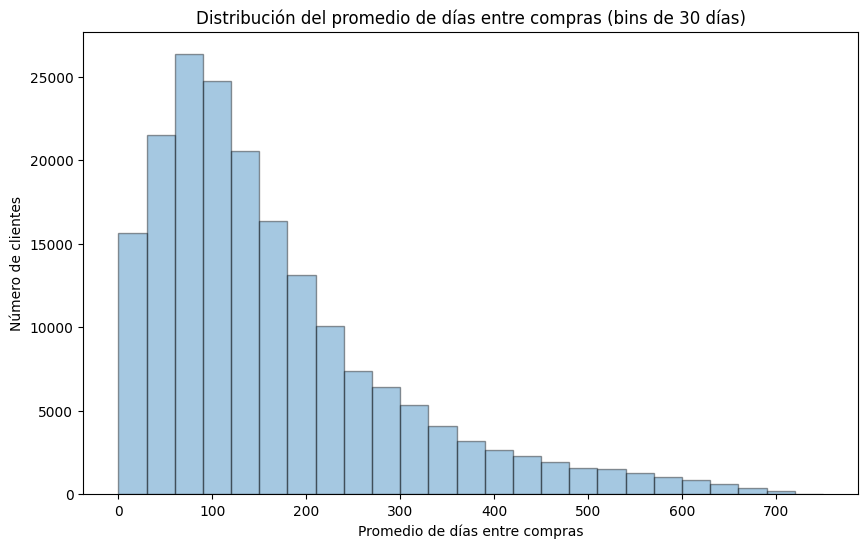

In [39]:
# Filtrar valores donde el promedio de días entre compras es mayor que 0
promedio_dias_filtrado = promedio_dias_compra[promedio_dias_compra['promedio_dias_compra'] > 0]

# Definir bins con intervalos más amplios (por ejemplo, de 10 días)
bin_width = 30  # Puedes probar con 15 o 20 si aún hay demasiados bins
bins = np.arange(0, promedio_dias_filtrado['promedio_dias_compra'].max() + bin_width, bin_width)

# Graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(promedio_dias_filtrado['promedio_dias_compra'], bins=bins, edgecolor='black', alpha=0.4)

# Etiquetas y título
plt.xlabel('Promedio de días entre compras')
plt.ylabel('Número de clientes')
plt.title(f'Distribución del promedio de días entre compras (bins de {bin_width} días)')

# Mostrar el gráfico
plt.show()


El histograma muestra cómo se distribuye el tiempo promedio que los clientes tardan en volver a comprar. La mayor parte de los clientes tienen un ciclo de recompra relativamente corto, lo que sugiere una buena frecuencia de compra en el negocio.

Segmento más común:
El intervalo con más clientes es [60-90 días], con 26,359 clientes (13.94%), seguido de cerca por [90-120 días] con 24,728 clientes (13.07%).

Clientes de recompra rápida:
Un 8.27% de los clientes vuelve a comprar en menos de 30 días, lo que representa 15,647 clientes con una alta frecuencia de compra.

In [33]:
# Filtrar valores donde el promedio de días entre compras es mayor que 0
promedio_dias_filtrado = promedio_dias_compra[promedio_dias_compra['promedio_dias_compra'] > 0]

# Definir bins con intervalos de 10 días
bin_width = 30
bins = np.arange(0, promedio_dias_filtrado['promedio_dias_compra'].max() + bin_width, bin_width)

# Crear categorías de bins
promedio_dias_filtrado['bin'] = pd.cut(promedio_dias_filtrado['promedio_dias_compra'], bins, right=False)

# Contar la cantidad de clientes por bin
bin_counts = promedio_dias_filtrado['bin'].value_counts().sort_index()

# Calcular porcentajes
total_clientes = bin_counts.sum()
bin_percentages = (bin_counts / total_clientes) * 100

# Crear un DataFrame con los resultados
tabla_bins = pd.DataFrame({
    'Intervalo (días)': bin_counts.index.astype(str),
    'Número de clientes': bin_counts.values,
    'Porcentaje (%)': bin_percentages.values
})

# Filtrar solo los bins con los porcentajes más altos (por ejemplo, el top 5)
top_bins = tabla_bins.sort_values(by='Porcentaje (%)', ascending=False).head(10)

# Mostrar la tabla con los bins más importantes
print(top_bins)


  Intervalo (días)  Número de clientes  Porcentaje (%)
2     [60.0, 90.0)               26359       13.935206
3    [90.0, 120.0)               24728       13.072946
1     [30.0, 60.0)               21514       11.373801
4   [120.0, 150.0)               20557       10.867864
5   [150.0, 180.0)               16389        8.664369
0      [0.0, 30.0)               15647        8.272096
6   [180.0, 210.0)               13112        6.931918
7   [210.0, 240.0)               10062        5.319475
8   [240.0, 270.0)                7381        3.902112
9   [270.0, 300.0)                6438        3.403576


In [40]:
df = pd.merge(df, promedio_dias_compra, on = 'customer_id', how = 'left')

In [41]:
df['promedio_dias_compra'].mean()

149.63199120694446

In [42]:
df = pd.merge(df, store, on="customer_id", how='left')

In [43]:
df = pd.merge(df, ventas_dto, on="customer_id", how='left')

In [44]:
df.rename(columns={1: "Store", 2: "Online"},inplace=True,)

In [45]:
# Crear la columna month+year
transactions['month+year'] = transactions['t_dat'].dt.to_period('M')

# Contar las filas por cada combinación de customer_Id y month+year
df_counts = transactions.groupby(['customer_id', 'month+year']).size().reset_index(name='row_count')

df_counts


,customer_id,month+year,row_count
0,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-06,1
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-08,1
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,2020-09,1
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09,1
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2019-01,2
...,...,...,...
832566,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,2019-10,1
832567,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,2020-04,2
832568,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,2019-01,1
832569,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,2020-07,1


In [46]:
# # Pivotar el DataFrame
# pivoted_df = df_counts.pivot_table(index='customer_id', columns='month+year', values='row_count', fill_value=0)

# # Reiniciar el índice para que customer_id sea una columna y no el índice
# pivoted_df.reset_index(inplace=True)
# pivoted_df

In [48]:
# df = pd.merge(df,pivoted_df, on = 'customer_id', how = 'left' )

In [49]:
merged_df = pd.merge(transactions,articles, on='article_id', how='left')

El análisis revela dos segmentos de clientes muy importantes, diferenciados tanto por su comportamiento de compra como por su edad, sea uno de ellos entre 18 y 35 y el otro entre 45 y 60.

Se ven diferencias en la cantidad de clientes en la base de datos como su comportamiento de compra, sea Online o en Store.

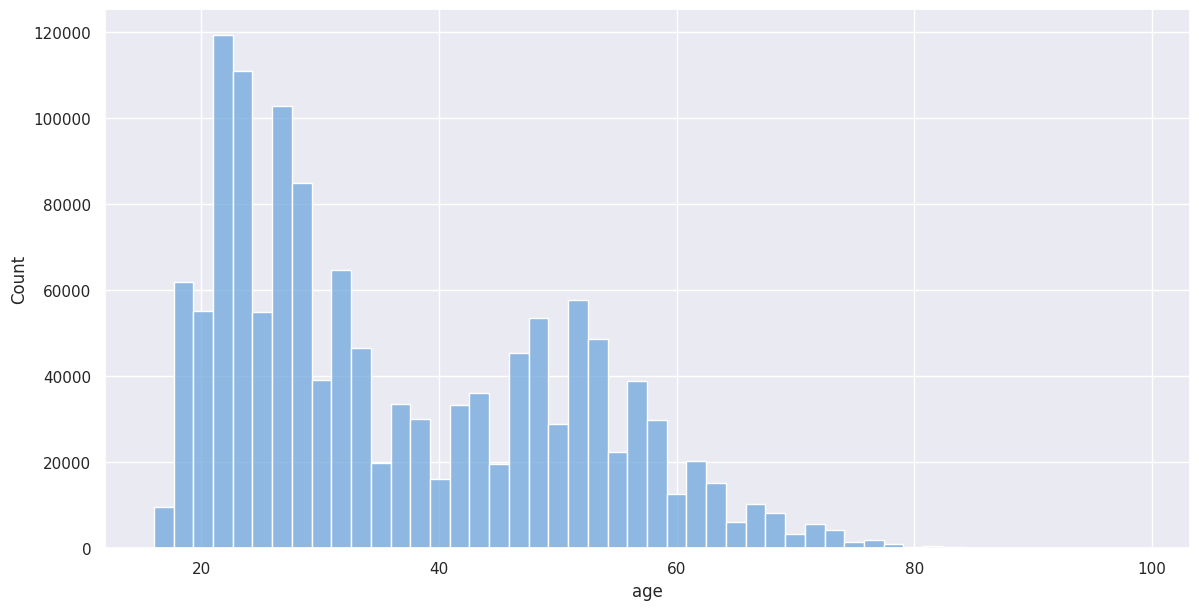

In [50]:
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

sns.histplot(data=customers, x="age", bins=50,color="#6fa8dc")
plt.show()

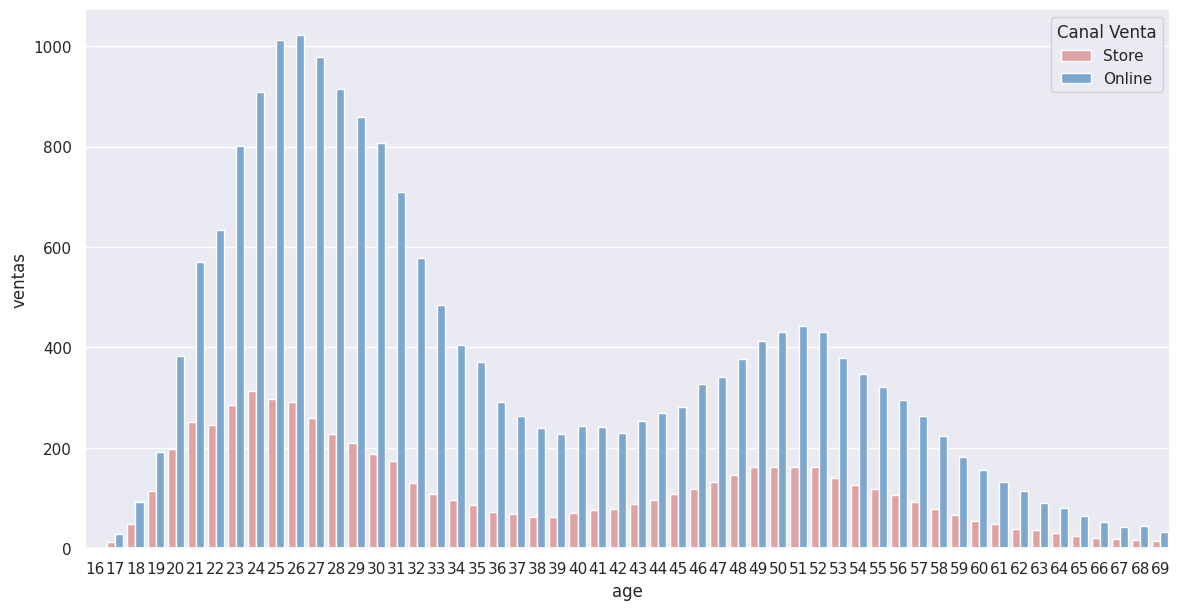

In [51]:
aux1 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id"]], customers[["customer_id",'age']])
aux1 = pd.DataFrame(aux1.groupby(['age', "sales_channel_id"], as_index=False).agg(ventas=('price', sum)))

# Create new dataframe column with the labels instead of numbers
aux1["sales_channel_id"] = aux1['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
aux1.rename(columns={"sales_channel_id": "Canal Venta"}, inplace = True)
aux1['age'] = aux1['age'].astype('Int64', errors='ignore' )
aux1 = aux1[aux1.age < 70]

plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

bar1 = sns.barplot(
    x="age",
    y="ventas",
    hue="Canal Venta",
    data=aux1,
    saturation=0.75,
    errcolor='.26',
    palette=['#ea9999', '#6fa8dc']  # Aplicando los colores personalizados
)

plt.show()


In [72]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,Precio_Prom,Min_Precio,Max_Precio,discount_amount,discount_percent,sale_type,n_trans,previous_visit,days_bw_visits,month+year
389885,2019-06-13,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,764280001,0.033881,2,0.032336,0.014797,0.033881,0.000000,0.000000,Venta Común,2019-06-13_0000423b00ade91418cceaf3b26c6af3dd3...,NaT,NaN,2019-06
468005,2019-08-27,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,732842008,0.067780,2,0.065934,0.057610,0.067780,0.000000,0.000000,Venta Común,2019-08-27_0000423b00ade91418cceaf3b26c6af3dd3...,2019-06-13,75.0,2019-08
942308,2020-09-14,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,448509014,0.042356,2,0.040832,0.021169,0.042356,0.000000,0.000000,Venta Común,2020-09-14_0000757967448a6cb83efb3ea7a3fb9d418...,NaT,NaN,2020-09
13215,2018-09-23,00007d2de826758b65a93dd24ce629ed66842531df6699...,605106001,0.008458,2,0.012056,0.006763,0.013542,0.005085,37.546934,Venta con Descuento,2018-09-23_00007d2de826758b65a93dd24ce629ed668...,NaT,NaN,2018-09
157764,2019-01-06,00007d2de826758b65a93dd24ce629ed66842531df6699...,351933001,0.016932,2,0.018866,0.003373,0.025407,0.008475,33.355570,Venta con Descuento,2019-01-06_00007d2de826758b65a93dd24ce629ed668...,2018-09-23,105.0,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718929,2020-04-09,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,559630026,0.022017,2,0.023044,0.011424,0.025407,0.003390,13.342228,Venta con Descuento,2020-04-09_ffffcd5046a6143d29a04fb8c424ce494a7...,2019-10-09,183.0,2020-04
744375,2020-04-09,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,879891001,0.028797,2,0.031484,0.025407,0.033881,0.005085,15.007504,Venta con Descuento,2020-04-09_ffffcd5046a6143d29a04fb8c424ce494a7...,2020-04-09,0.0,2020-04
141606,2019-01-24,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,592986002,0.006763,2,0.019564,0.006051,0.059305,0.052542,88.596742,Venta con Descuento,2019-01-24_ffffcf35913a0bee60e8741cb2b4e78b8a9...,NaT,NaN,2019-01
866732,2020-07-03,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,816759002,0.016932,2,0.016248,0.013542,0.016932,0.000000,0.000000,Venta Común,2020-07-03_ffffcf35913a0bee60e8741cb2b4e78b8a9...,2019-01-24,526.0,2020-07


In [52]:
# Contar el número de cada tipo de venta
sale_type_counts = transactions['sale_type'].value_counts().reset_index()
sale_type_counts.columns = ['sale_type', 'count']

En el siguiente cuadro se visualiza la paridad entre las ventas que se realizan con y sin descuento.

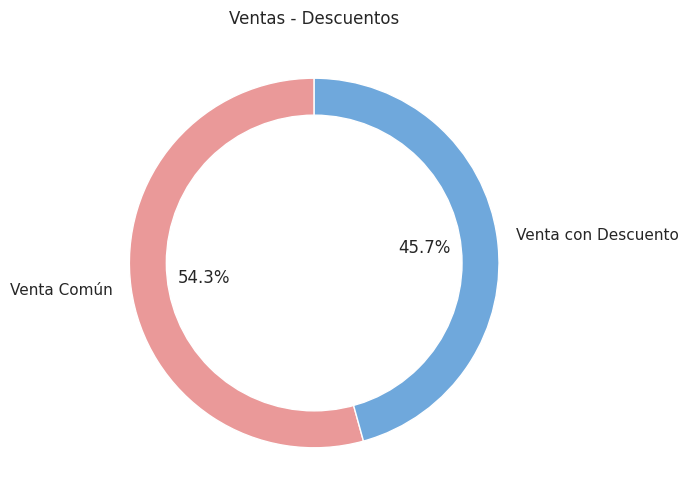

In [53]:
colors = ['#ea9999', '#6fa8dc']

plt.figure(figsize=(6, 6))
plt.pie(sale_type_counts['count'], labels=sale_type_counts['sale_type'], colors=colors, autopct='%1.1f%%', startangle=90)

my_circle = plt.Circle((0, 0), 0.8, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Ventas - Descuentos')

plt.show()


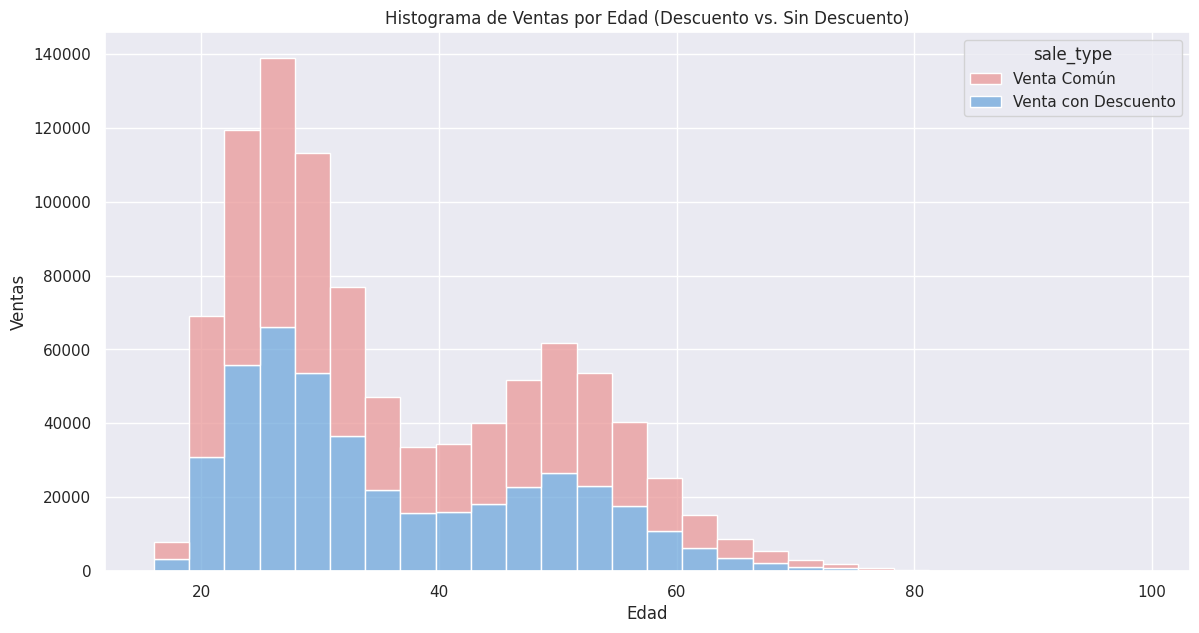

In [74]:
# Unir transactions con customers para obtener la edad
aux4 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id", 'sale_type']],
                customers[["customer_id", 'age']])

# Filtrar por edad y sale_type (con descuento o sin descuento)
aux4['sale_type'] = aux4['sale_type'].replace({1: 'Descuento', 2: 'Sin Descuento'})

# Graficar el histograma por edad con el color hue dependiendo de si tiene descuento o no
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

# Histograma con la edad como eje X y el total de ventas en el eje Y, coloreado por tipo de venta
histogram = sns.histplot(
    data=aux4,
    x="age",
    hue="sale_type",
    multiple="stack",  # Apilar las barras de los tipos de venta
    kde=False,         # No incluir la curva de densidad
    palette=['#ea9999', '#6fa8dc'],  # Colores para 'Descuento' y 'Sin Descuento'
    binwidth=3,        # Tamaño de los bins
)

plt.title('Histograma de Ventas por Edad (Descuento vs. Sin Descuento)')
plt.xlabel('Edad')
plt.ylabel('Ventas')
plt.show()


In [ ]:
art = articles.groupby('index_group_name', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)
art

,index_group_name,Cantidad
2,Ladieswear,39737
0,Baby/Children,34711
1,Divided,15149
3,Menswear,12553
4,Sport,3392


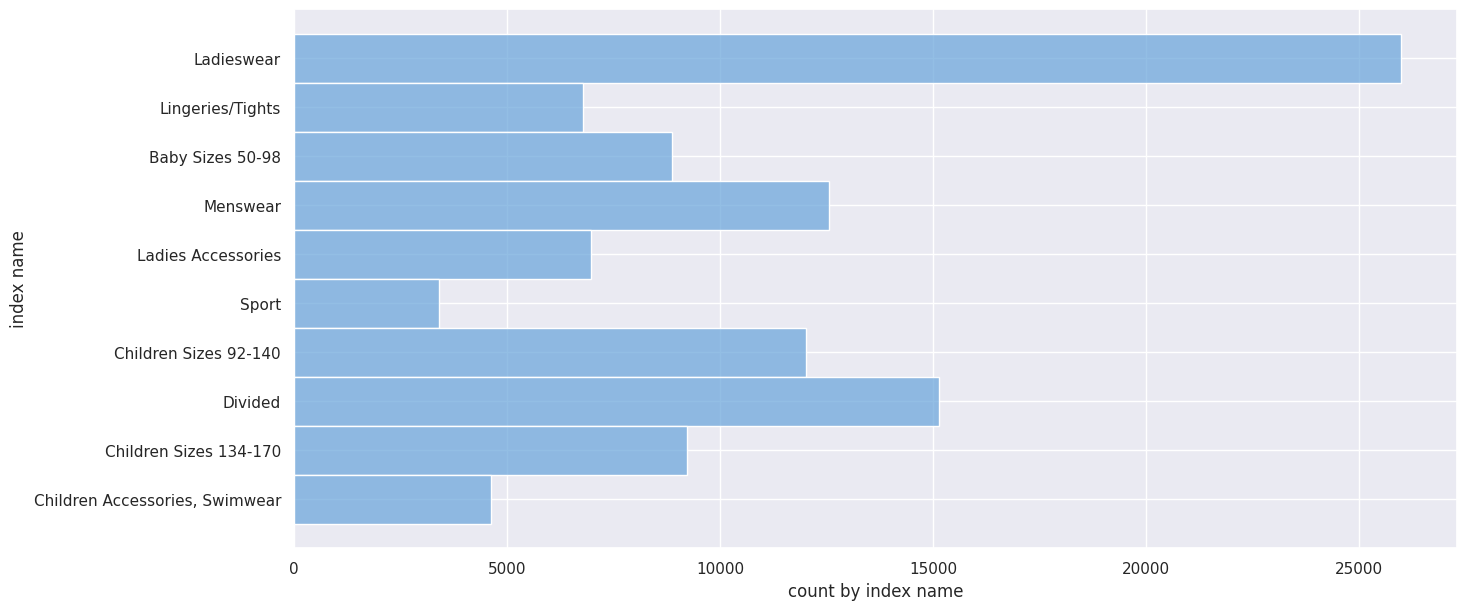

In [52]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name', color="#6fa8dc")
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

Se visualiza que del total de ventas, la mayoria corresponden a la categoria ladieswear.

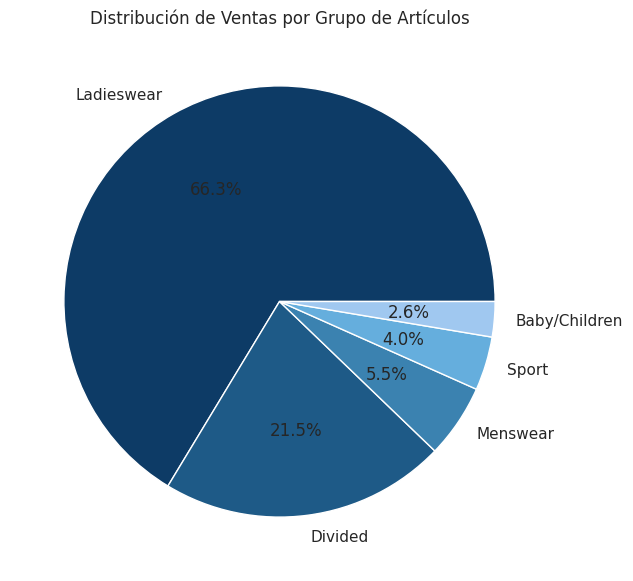

In [56]:
aux2 = pd.merge(transactions[["article_id", 'price']], articles[["article_id",'index_group_name']])
aux2 = aux2.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))

# Ordenar los datos por ventas
ordered_df = aux2.sort_values(by='ventas', ascending=False)

# Definir una lista de 5 colores de azul (de más oscuro a más claro)
blue_colors = ['#0d3b66', '#1e5a87', '#3b82b0', '#65aedd', '#a0c8f0']

# Crear el gráfico de torta con los colores definidos
fig, ax = plt.subplots(figsize=(10, 7))
ax.pie(ordered_df['ventas'], labels=ordered_df['index_group_name'], autopct='%1.1f%%', colors=blue_colors)

# Título
plt.title("Distribución de Ventas por Grupo de Artículos")

# Mostrar el gráfico
plt.show()


Se visualizan ciertos picos de ventas por día, por dias festivos y/o descuentos.

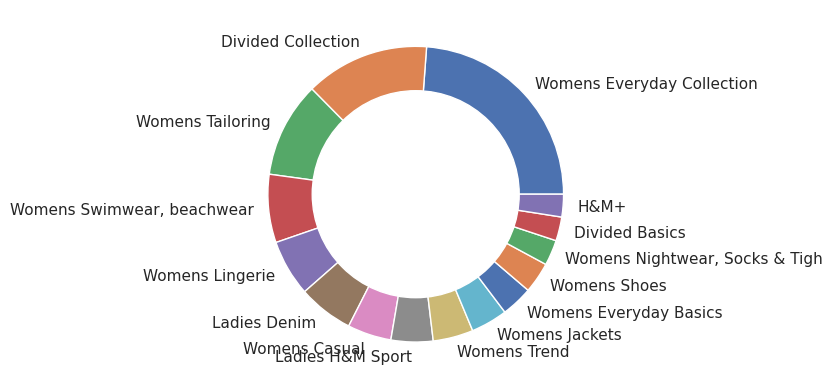

In [61]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfm = dfm.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Not enough colors --> colors will cycle
plt.pie(dfm["ventas"], labels=dfm["section_name"])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

In [55]:
ventaspdia= transactions.groupby(['t_dat'], as_index=False).agg(ventas=('price', sum))

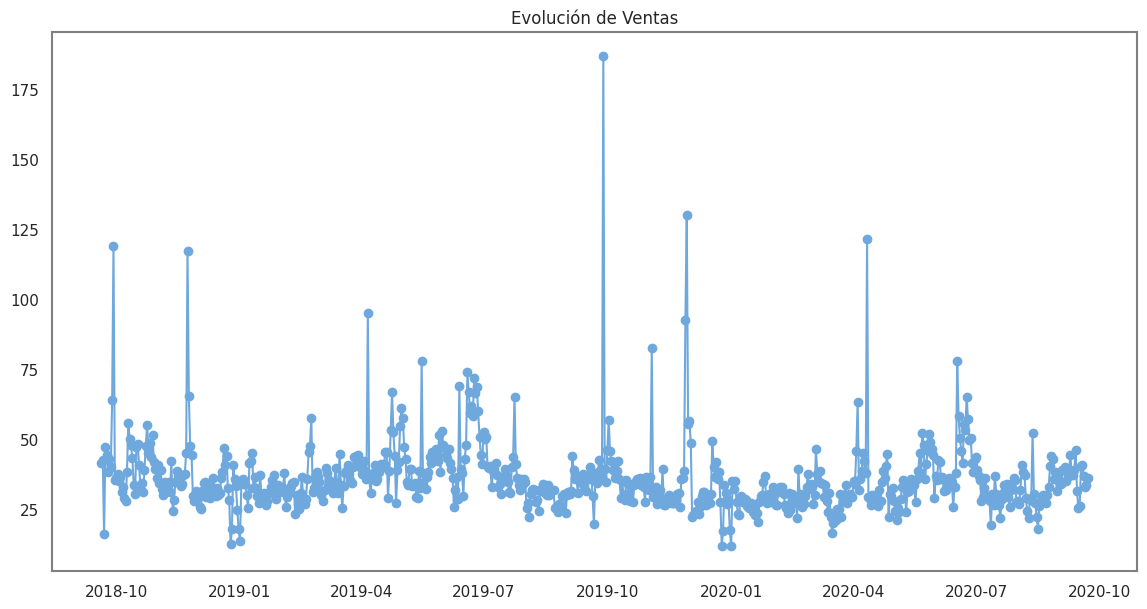

In [56]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(14,7))

# Configurar el fondo blanco y sin líneas de fondo
ax.set_facecolor('white')  # Fondo blanco
ax.grid(False)  # Desactivar las líneas de la cuadrícula

# Graficar los datos con línea celeste
plt.plot('t_dat', 'ventas', data=ventaspdia, marker='o', color='#6fa8dc')
plt.title("Evolución de Ventas")

# Agregar borde alrededor del gráfico con color gris
for spine in ax.spines.values():
    spine.set_edgecolor('gray')  # Color del borde
    spine.set_linewidth(1.5)  # Grosor del borde

# Mostrar el gráfico
plt.show()


En el siguiente cuadro, se analiza el comportamiento de ventas y su evolución entre los dos canales de venta: Online y Store.

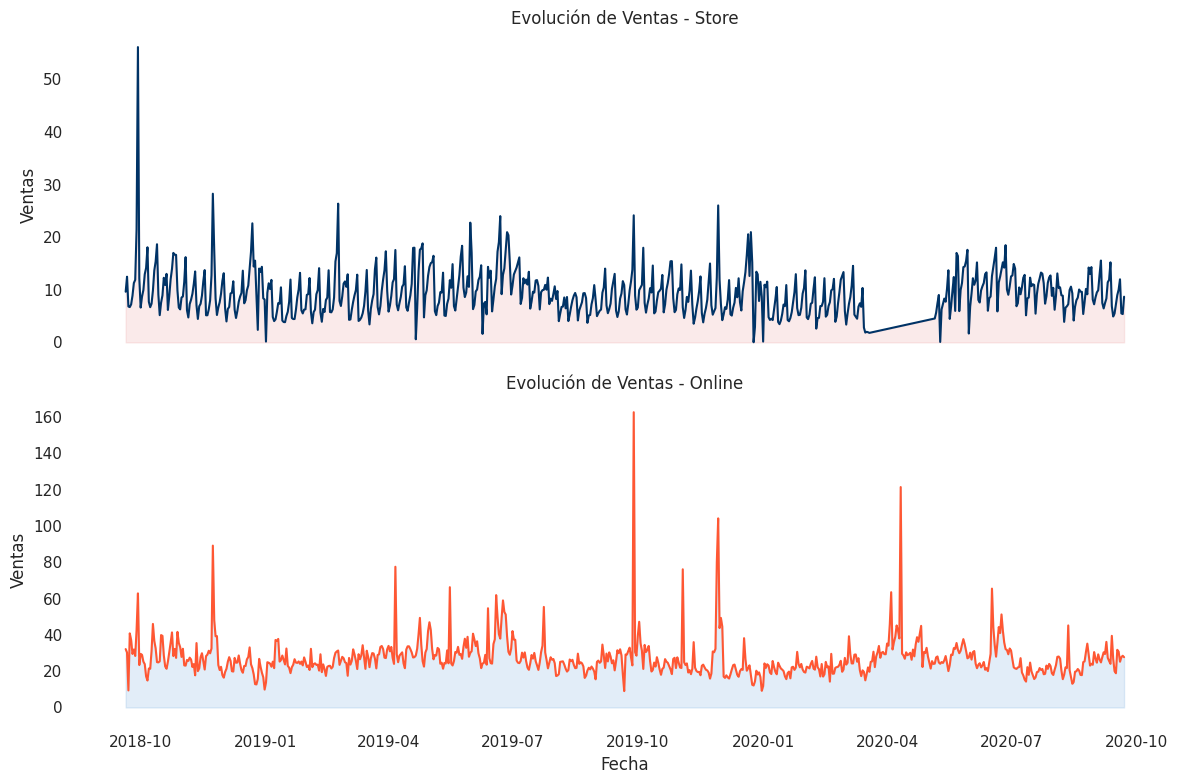

In [60]:
# Agrupar datos
aux3 = transactions.groupby(['t_dat', 'sales_channel_id'], as_index=False).agg(ventas=('price', sum))
aux3["sales_channel_id"] = aux3['sales_channel_id'].replace([1, 2], ['Store', 'Online'])

# Separar los datos en dos DataFrames
store_sales = aux3[aux3['sales_channel_id'] == 'Store']
online_sales = aux3[aux3['sales_channel_id'] == 'Online']

# Crear la figura y los ejes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Gráfico para ventas en tienda
axes[0].plot(store_sales['t_dat'], store_sales['ventas'], color='#003366', label='Store')
axes[0].fill_between(store_sales['t_dat'], store_sales['ventas'], alpha=0.2, color='#ea9999')
axes[0].set_title('Evolución de Ventas - Store')
axes[0].set_ylabel('Ventas')
axes[0].set_facecolor('white')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Gráfico para ventas online
axes[1].plot(online_sales['t_dat'], online_sales['ventas'], color='#FF5733', label='Online')  # Naranja
axes[1].fill_between(online_sales['t_dat'], online_sales['ventas'], alpha=0.2, color='#6fa8dc')
axes[1].set_title('Evolución de Ventas - Online')
axes[1].set_ylabel('Ventas')
axes[1].set_xlabel('Fecha')
axes[1].set_facecolor('white')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Ajustar espaciado
plt.tight_layout()
plt.show()


En los siguientes graficos se analiza el comportamiento y tendencia de ventas, desde las ventas totales por mes hasta las ventas por tipo de producto, con y sin descuento, Store y Online.

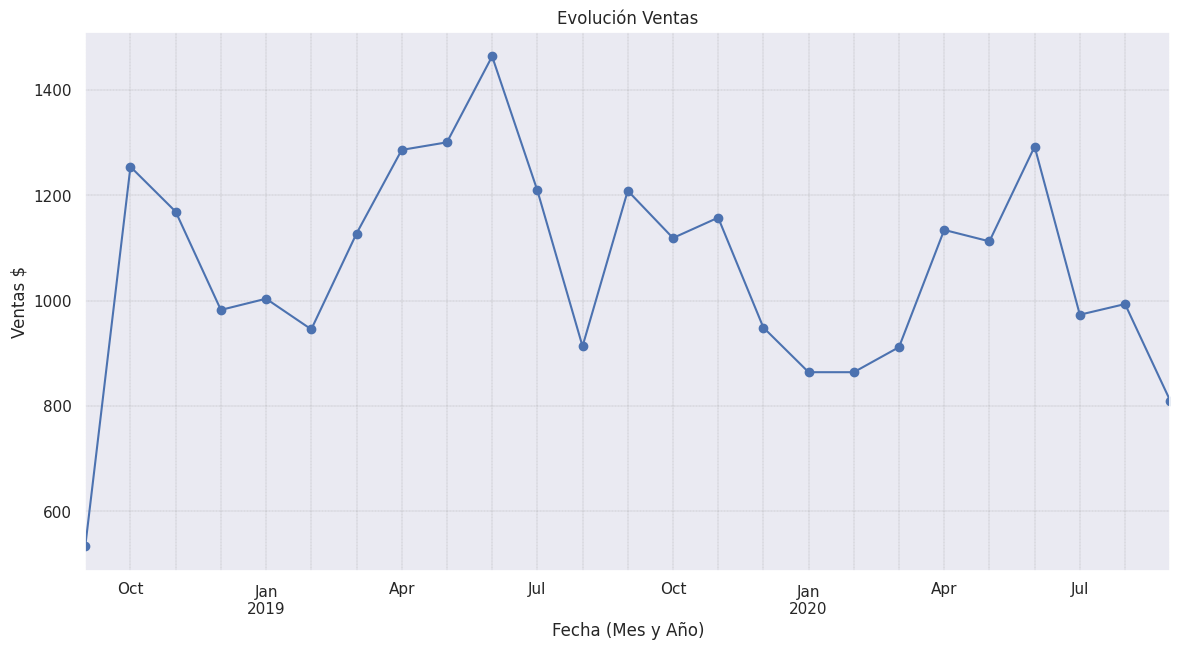

In [57]:
# Sumar las ventas totales por `month+year`
total_sales_by_month = merged_df.groupby('month+year')['price'].sum()

# Crear el gráfico de líneas
total_sales_by_month.plot(kind='line', figsize=(14, 7), marker='o')

plt.title('Evolución Ventas')
plt.xlabel('Fecha (Mes y Año)')
plt.ylabel('Ventas $')
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.2)
plt.show()


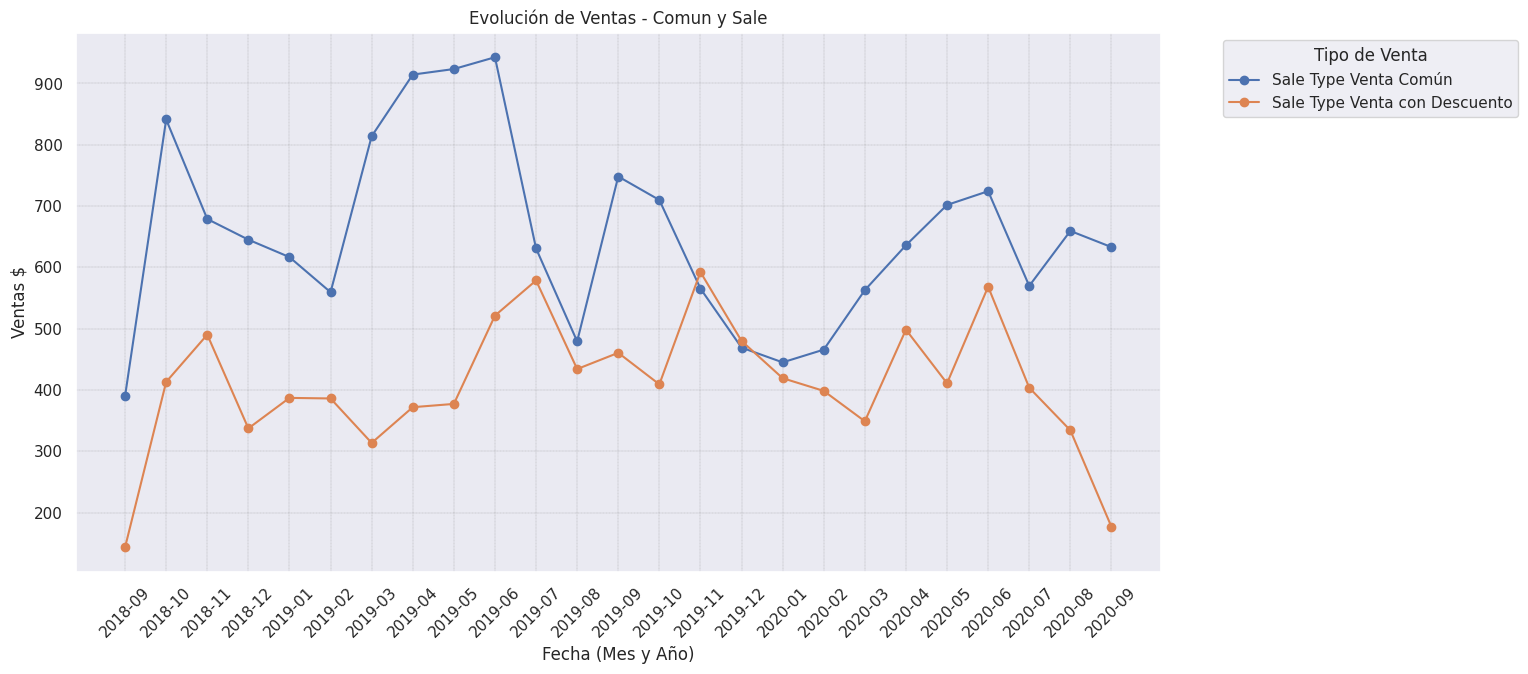

In [58]:
# Sumar las ventas por `month+year` y `sale_type`
sales_by_type = merged_df.groupby(['month+year', 'sale_type'])['price'].sum().unstack().fillna(0)

# Convertir el índice `month+year` de Period a string
sales_by_type.index = sales_by_type.index.astype(str)

# Crear el gráfico de líneas con dos líneas
plt.figure(figsize=(14, 7))

for sale_type in sales_by_type.columns:
    plt.plot(sales_by_type.index, sales_by_type[sale_type], marker='o', label=f'Sale Type {sale_type}')

plt.title('Evolución de Ventas - Comun y Sale')
plt.xlabel('Fecha (Mes y Año)')
plt.ylabel('Ventas $')
plt.legend(title='Tipo de Venta', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.2)

# Rotar las etiquetas del eje x
plt.xticks(rotation=45)
plt.show()



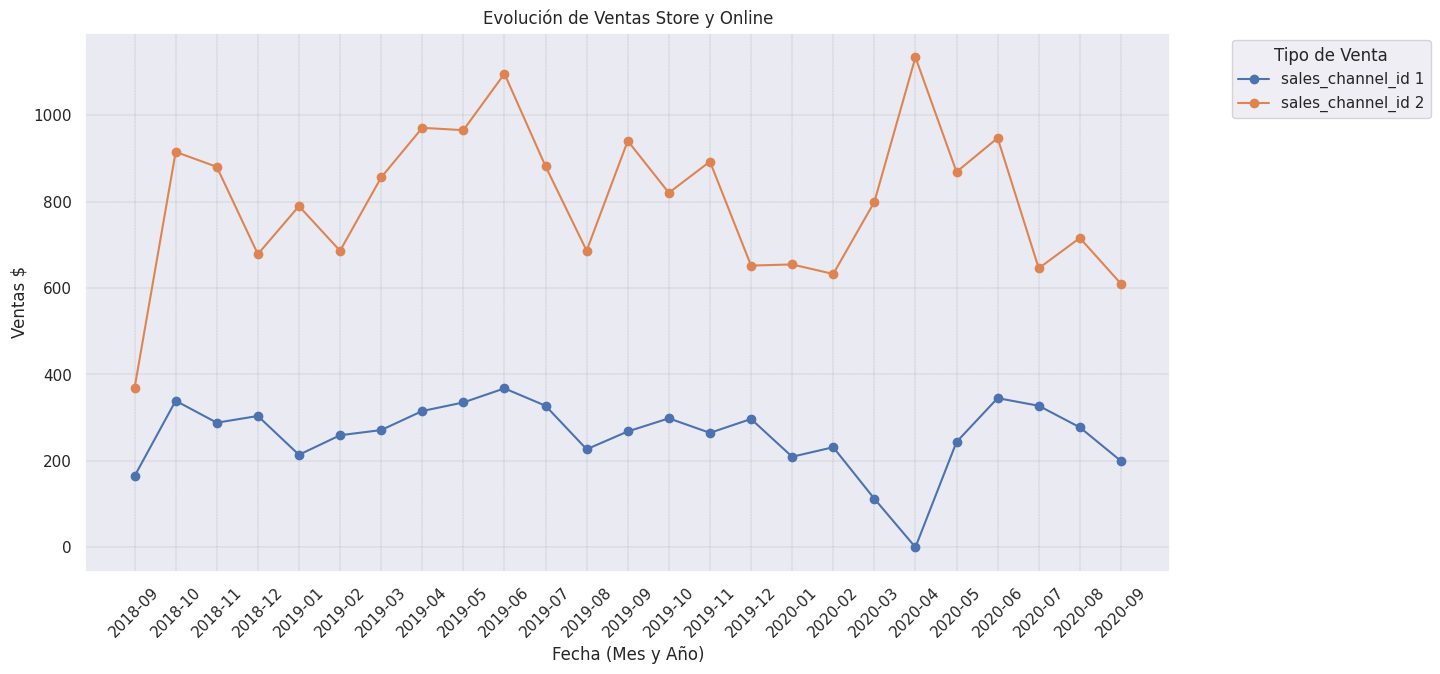

In [59]:
# Sumar las ventas por `month+year` y `sales_channel_id`
sales_by_channel = merged_df.groupby(['month+year', 'sales_channel_id'])['price'].sum().unstack().fillna(0)

# Convertir el índice `month+year` de Period a string
sales_by_channel.index = sales_by_channel.index.astype(str)

# Crear el gráfico de líneas con dos líneas
plt.figure(figsize=(14, 7))

for sales_channel_id in sales_by_channel.columns:
    plt.plot(sales_by_channel.index, sales_by_channel[sales_channel_id], marker='o', label=f'sales_channel_id {sales_channel_id}')

plt.title('Evolución de Ventas Store y Online')
plt.xlabel('Fecha (Mes y Año)')
plt.ylabel('Ventas $')
plt.legend(title='Tipo de Venta', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.2)

# Rotar las etiquetas del eje x
plt.xticks(rotation=45)
plt.show()


##### Ventas por Tipo de Productos

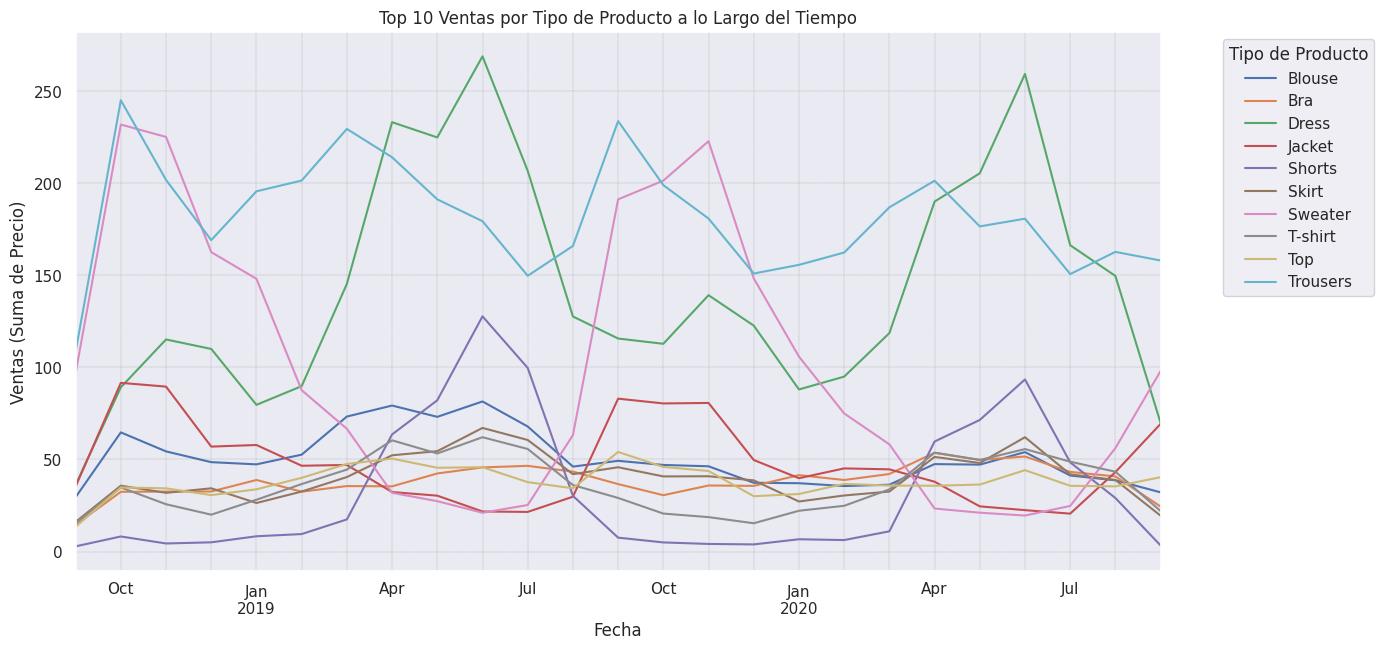

In [60]:
# Join los datasets transactions y articles
merged_df = pd.merge(transactions,articles, on='article_id', how='left')
# Crear la columna `month+year` a partir de `t_dat`
merged_df['month+year'] = merged_df['t_dat'].dt.to_period('M')

# Sumar las ventas totales por `product_type_name`
total_sales_by_product = merged_df.groupby('product_type_name')['price'].sum()

# Seleccionar los top 10 tipos de producto con más ventas
top_10_products = total_sales_by_product.nlargest(10).index

# Filtrar el DataFrame original para incluir solo los top 10 tipos de producto
filtered_df = merged_df[merged_df['product_type_name'].isin(top_10_products)]

# Agregar las ventas por `product_type_name` y `month+year`
sales_by_product = filtered_df.groupby(['month+year', 'product_type_name'])['price'].sum().unstack()

# Crear el gráfico de líneas
sales_by_product.plot(kind='line', figsize=(14, 7))

plt.title('Top 10 Ventas por Tipo de Producto a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Suma de Precio)')
plt.legend(title='Tipo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.2)
plt.show()


##### Ventas por Grupos de Productos

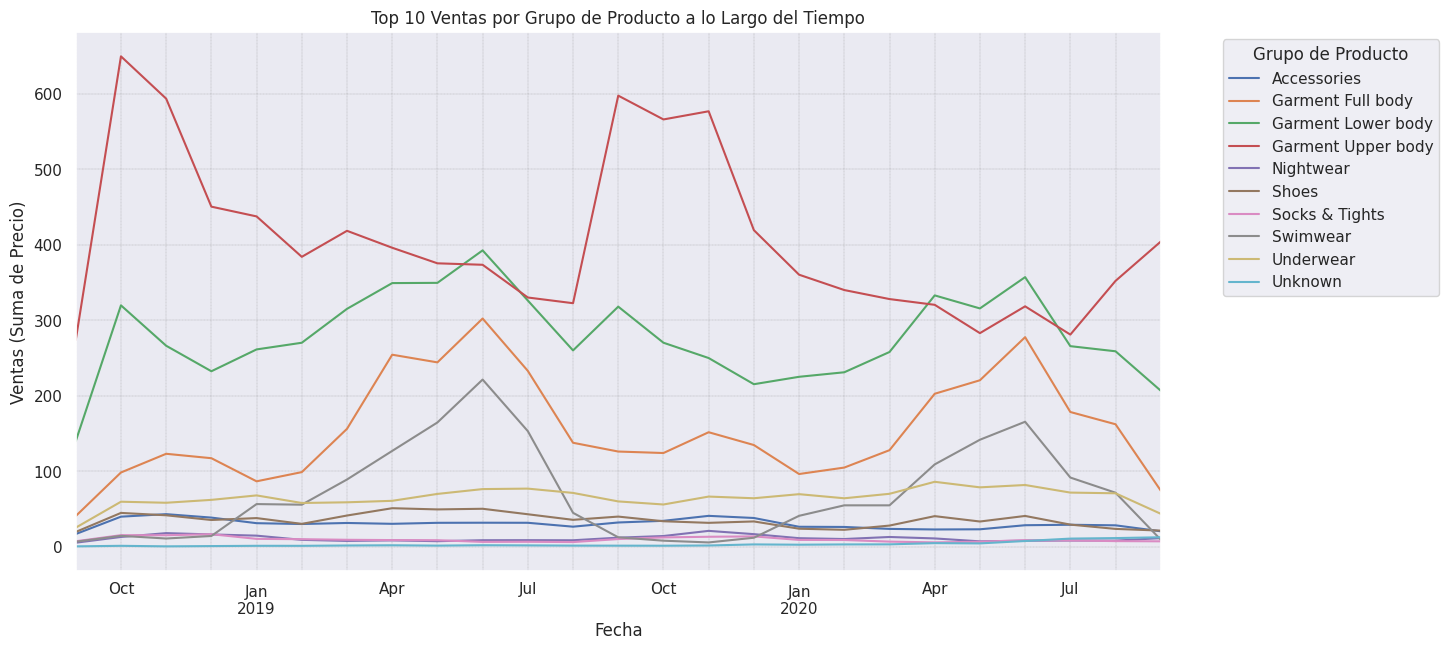

In [61]:
# Sumar las ventas totales por `product_group_name`
total_sales_by_group = merged_df.groupby('product_group_name')['price'].sum()

# Seleccionar los top 10 grupos de producto con más ventas
top_10_groups = total_sales_by_group.nlargest(10).index

# Filtrar el DataFrame original para incluir solo los top 10 grupos de producto
filtered_df = merged_df[merged_df['product_group_name'].isin(top_10_groups)]

# Agregar las ventas por `product_group_name` y `month+year`
sales_by_group = filtered_df.groupby(['month+year', 'product_group_name'])['price'].sum().unstack()

# Crear el gráfico de líneas
sales_by_group.plot(kind='line', figsize=(14, 7))

plt.title('Top 10 Ventas por Grupo de Producto a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas (Suma de Precio)')
plt.legend(title='Grupo de Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.2)
plt.show()


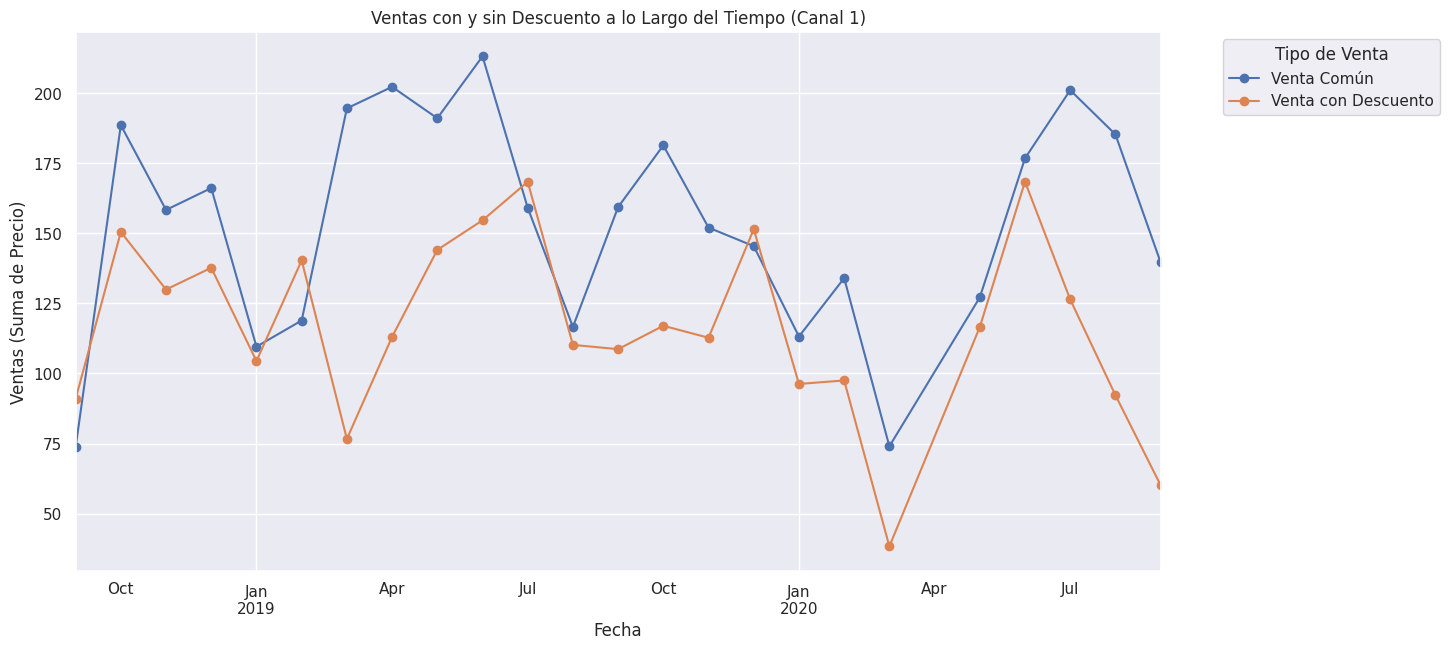

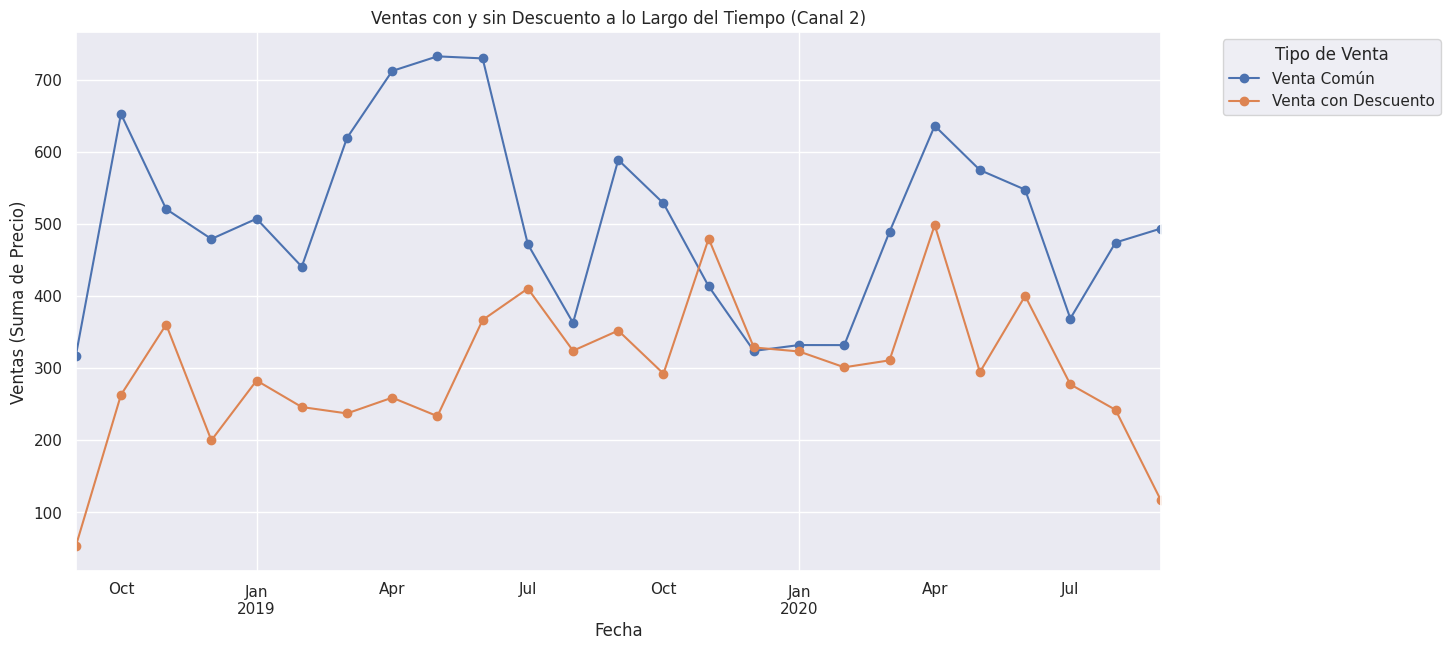

In [62]:
# Filtrar por `sales_channel_id` igual a 1 y 2
for channel_id in [1, 2]:
    channel_df = merged_df[merged_df['sales_channel_id'] == channel_id]

    # Agrupar las ventas totales por `month+year` y `sale_type`
    sales_by_discount = channel_df.groupby(['month+year', 'sale_type'])['price'].sum().unstack()

    # Crear el gráfico de líneas
    sales_by_discount.plot(kind='line', figsize=(14, 7), marker='o')

    plt.title(f'Ventas con y sin Descuento a lo Largo del Tiempo (Canal {channel_id})')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas (Suma de Precio)')
    plt.legend(title='Tipo de Venta', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


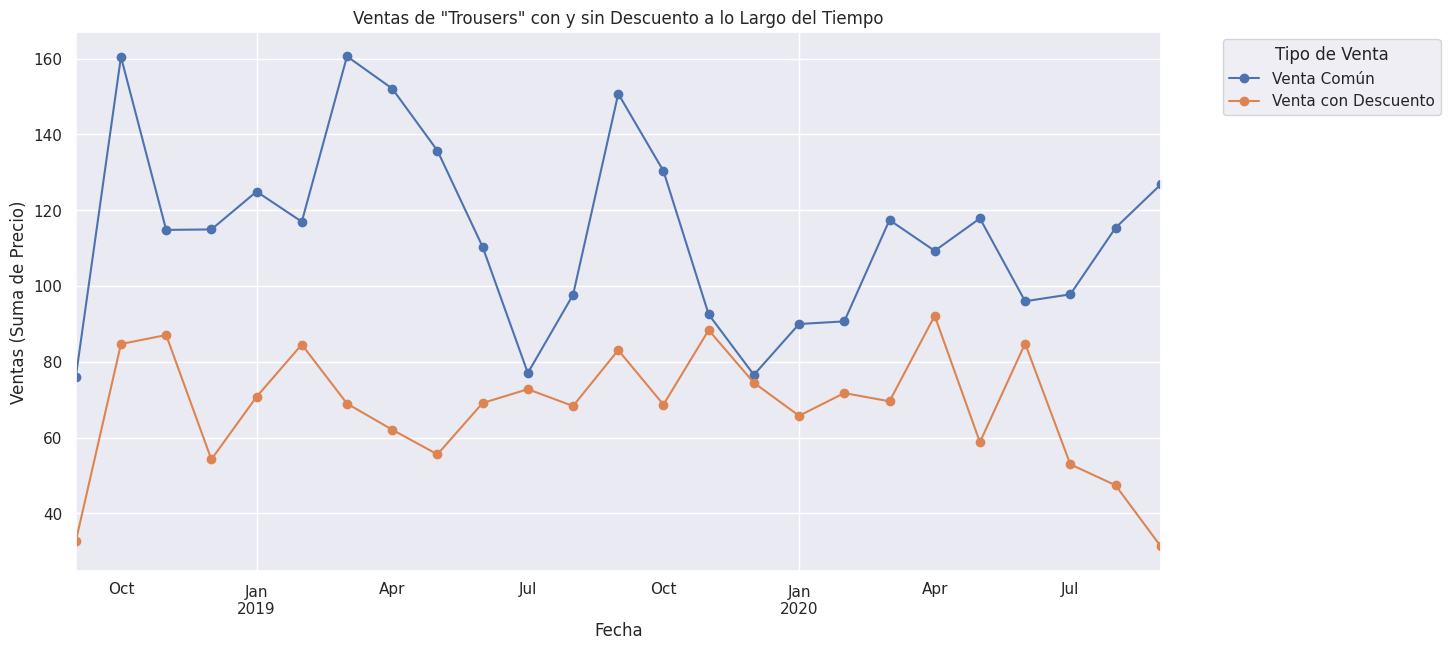

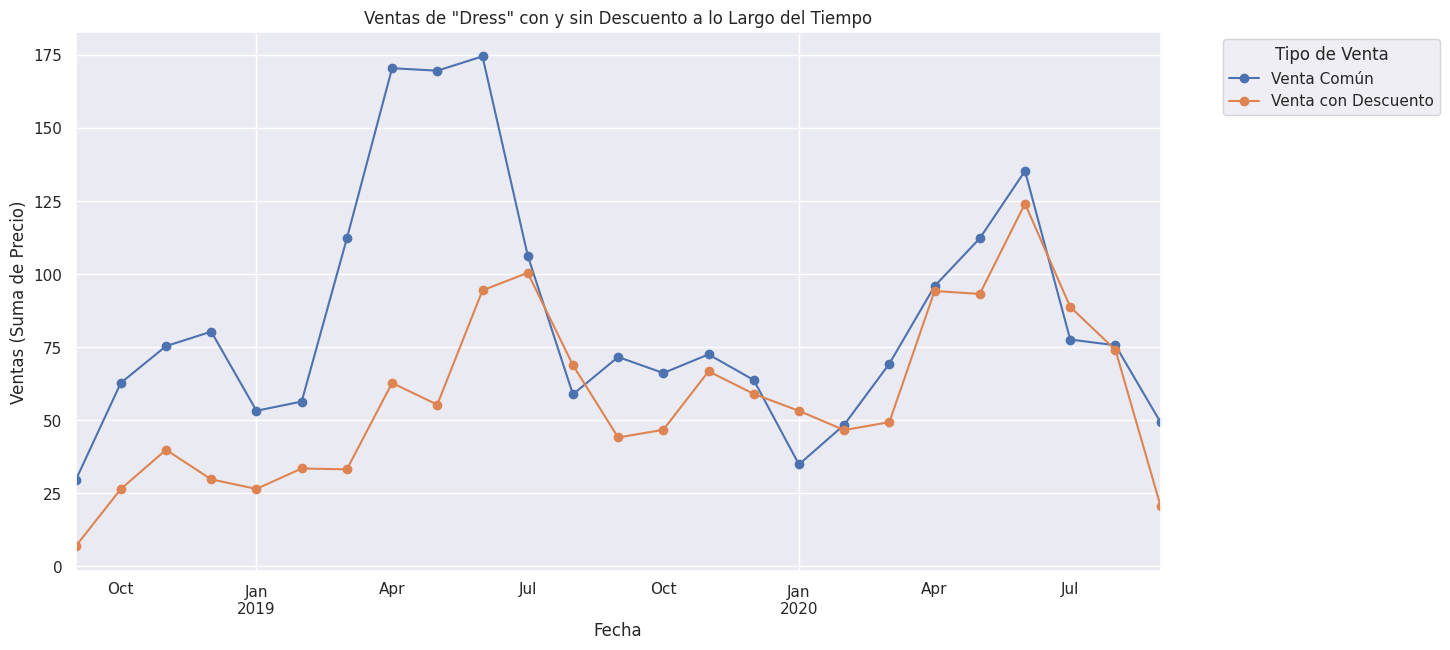

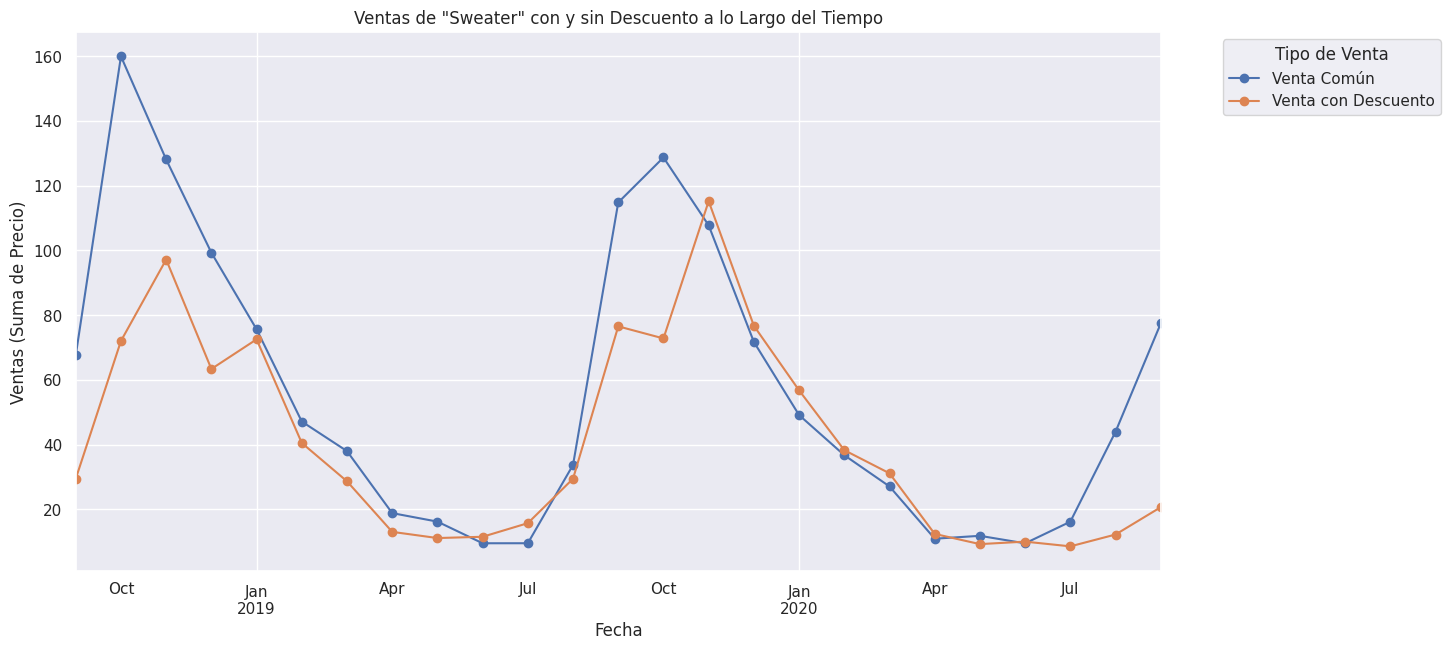

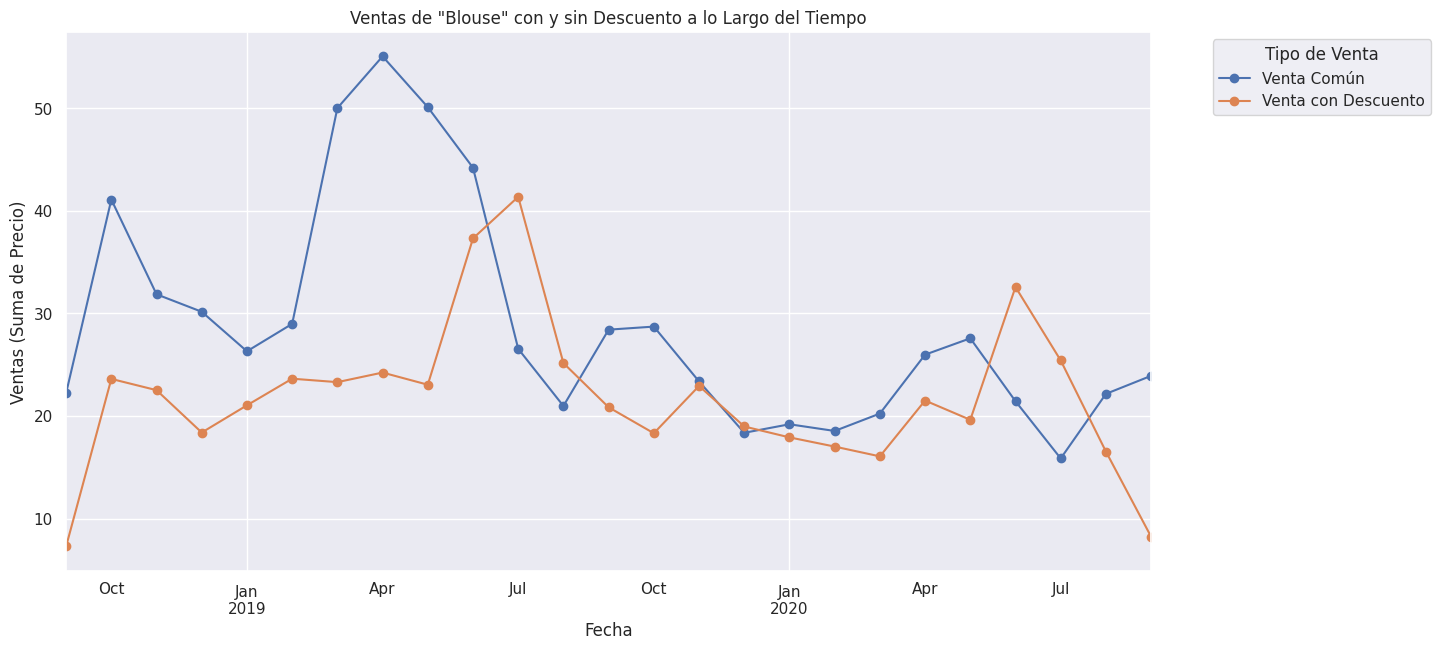

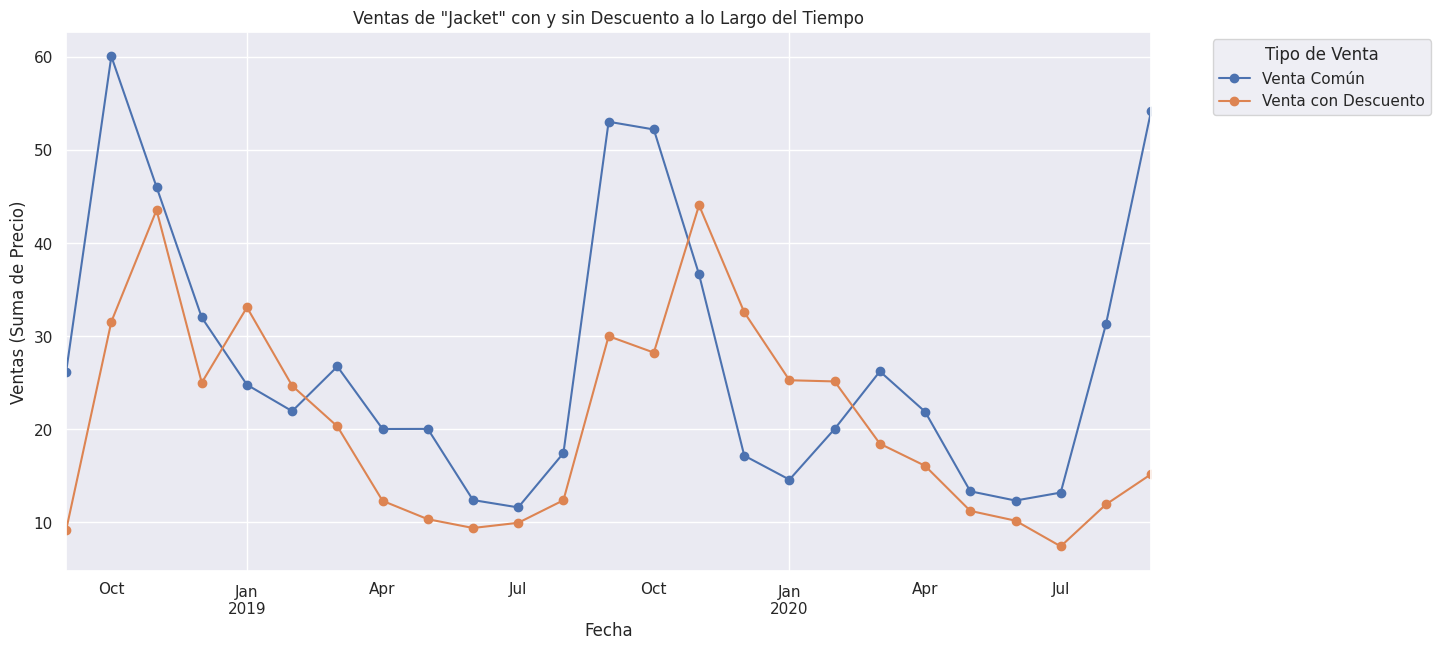

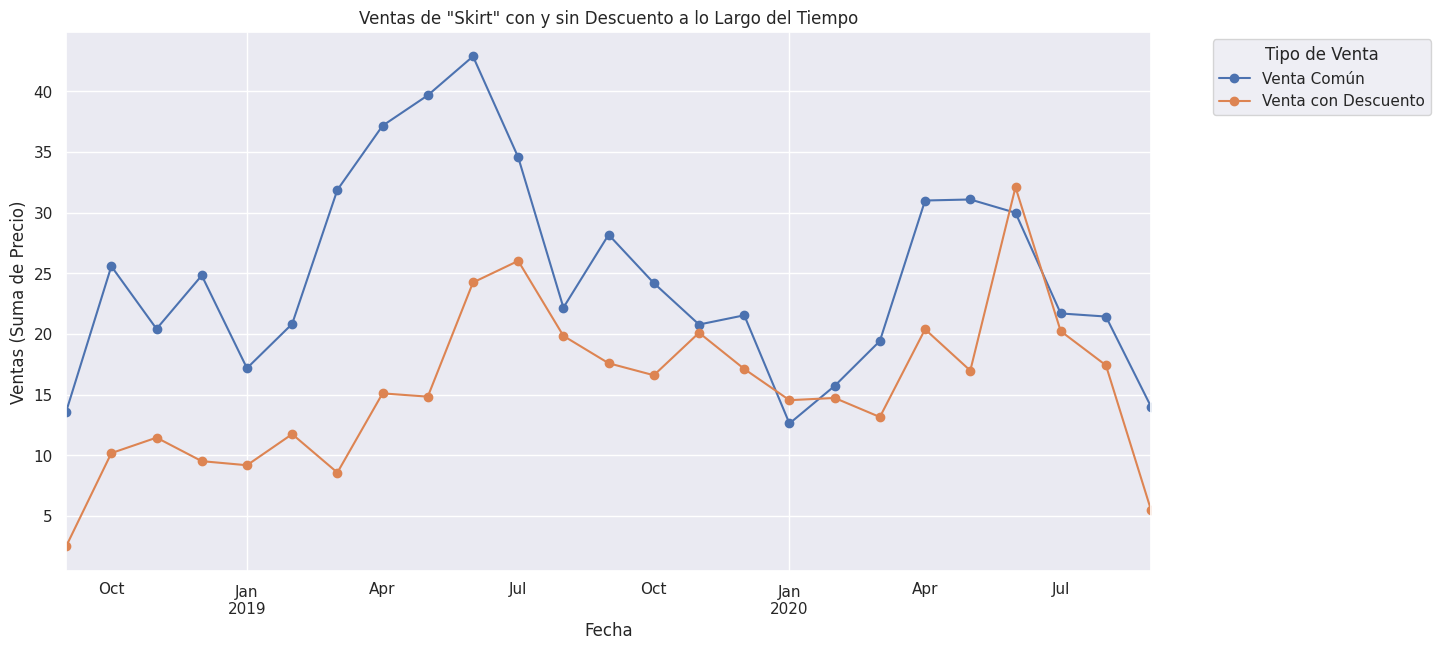

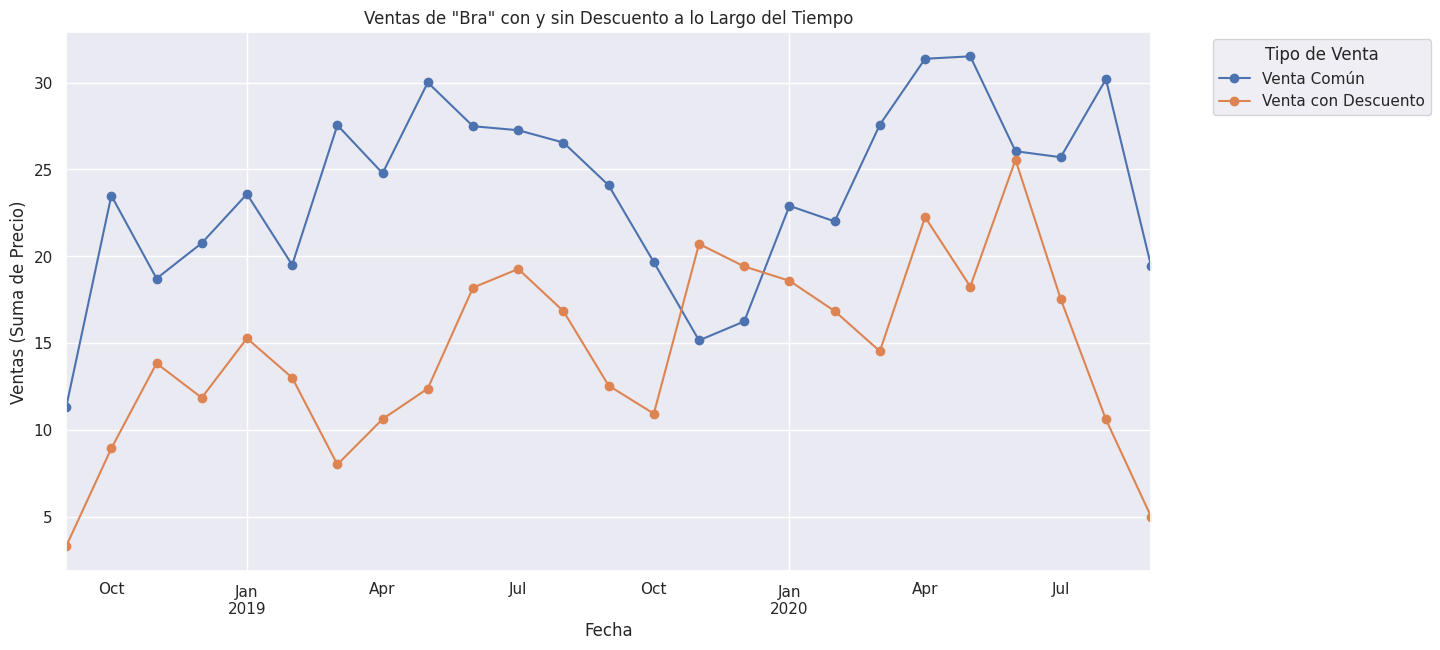

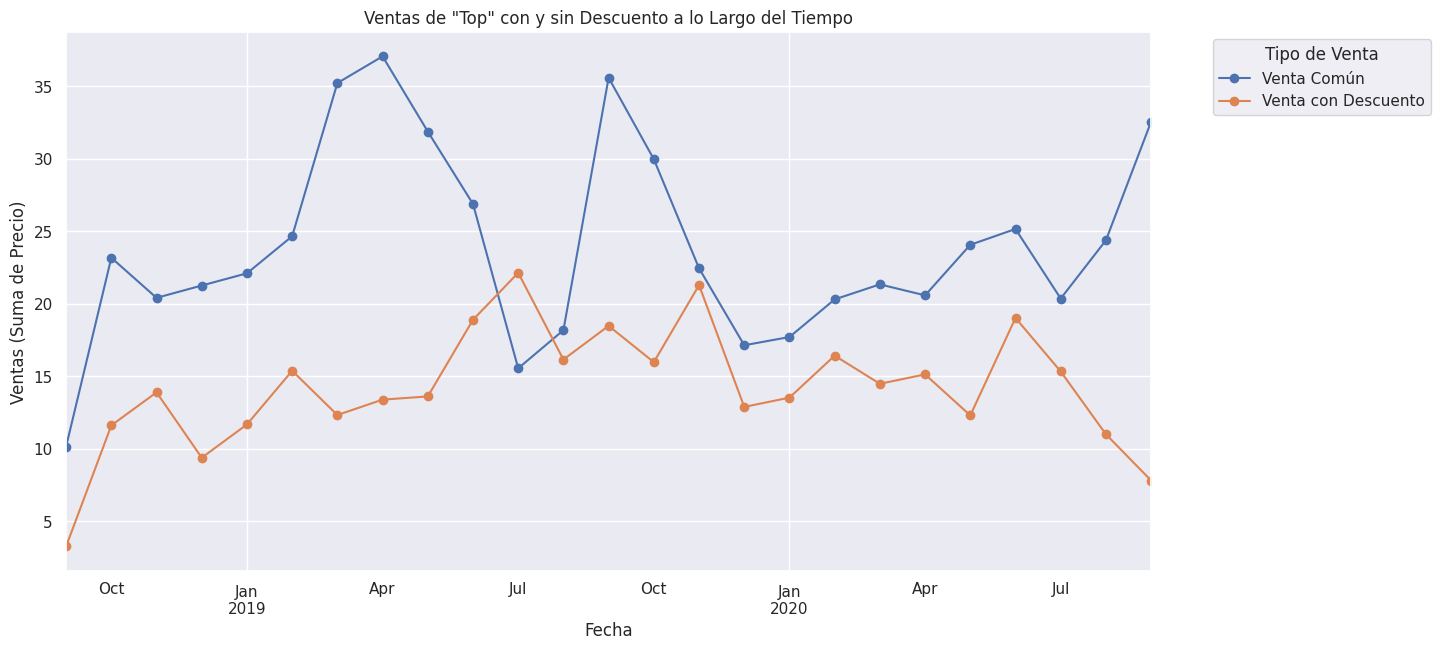

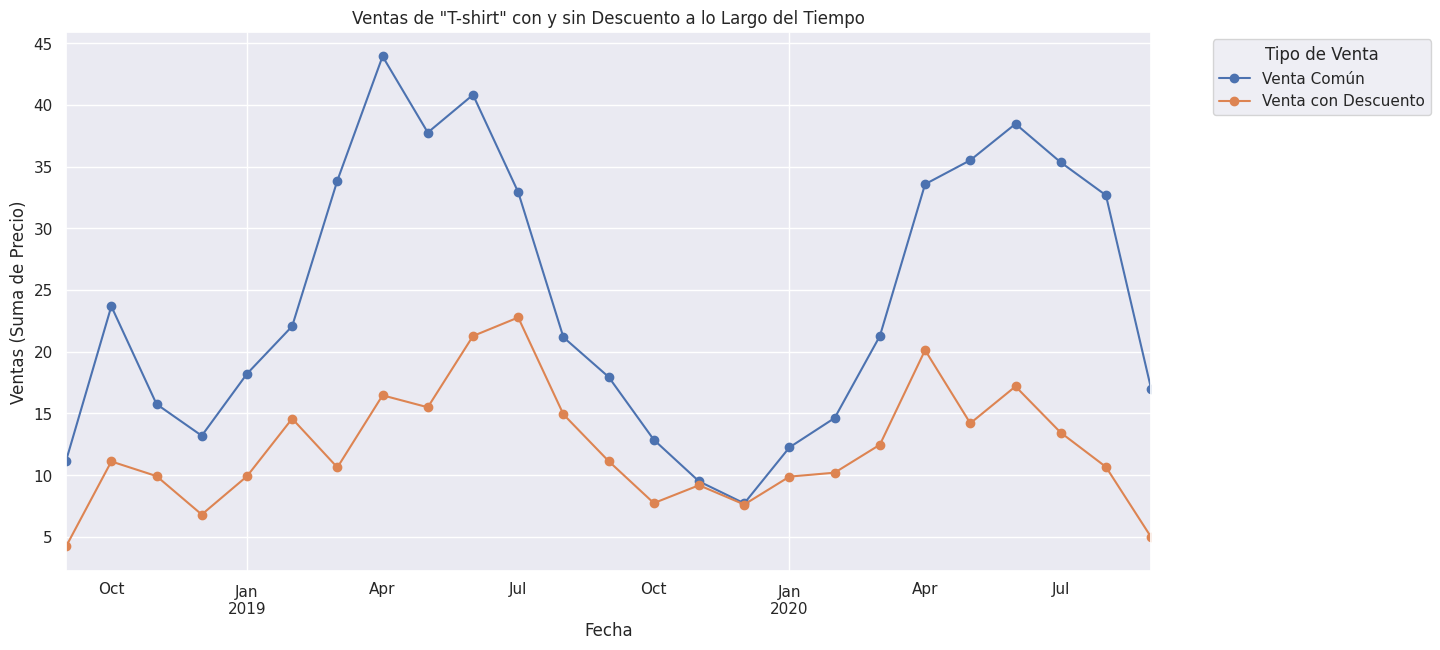

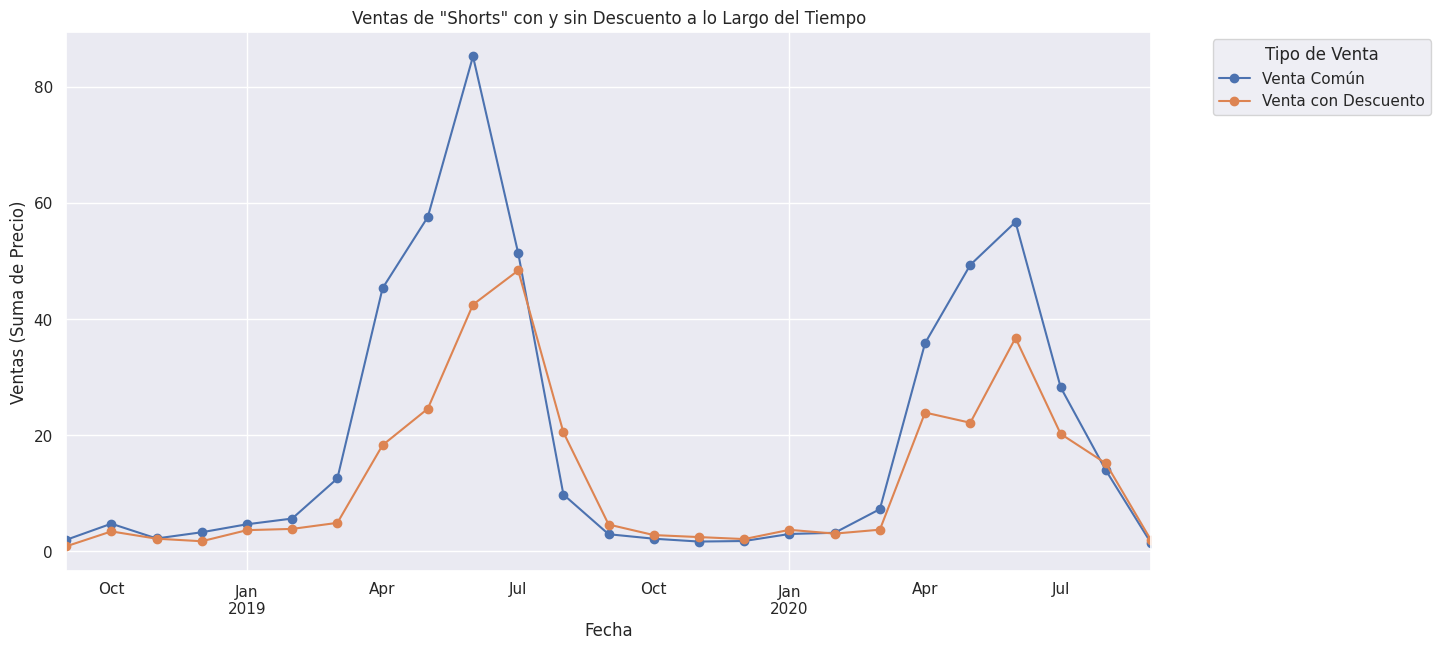

In [63]:
# Crear la columna `month+year` a partir de `t_dat`
merged_df['month+year'] = merged_df['t_dat'].dt.to_period('M')

# Sumar las ventas totales por `product_type_name`
total_sales_by_product = merged_df.groupby('product_type_name')['price'].sum()

# Seleccionar los top 10 tipos de producto con más ventas
top_10_products = total_sales_by_product.nlargest(10).index

# Filtrar el DataFrame original para incluir solo los top 10 tipos de producto
filtered_df = merged_df[merged_df['product_type_name'].isin(top_10_products)]

# Graficar por separado cada tipo de producto
for product in top_10_products:
    # Filtrar el DataFrame por el tipo de producto actual
    product_df = filtered_df[filtered_df['product_type_name'] == product]

    # Agrupar las ventas por `month+year` y `sale_type`
    sales_by_discount = product_df.groupby(['month+year', 'sale_type'])['price'].sum().unstack()

    # Crear el gráfico de líneas
    sales_by_discount.plot(kind='line', figsize=(14, 7), marker='o')

    plt.title(f'Ventas de "{product}" con y sin Descuento a lo Largo del Tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas (Suma de Precio)')
    plt.legend(title='Tipo de Venta', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()


In [64]:
# Summarize total sales and count by 'product_type_name'
total_sales_by_product = merged_df.groupby(
    ['month+year', 'product_group_name', 'product_type_name', 'sales_channel_id', 'sale_type'],
    as_index=False
).agg(
    ventas=('price', 'sum'),  # Sum of sales by price
    Cantidad=('price', 'count')  # Count the number of rows
)

# Display information about the resulting DataFrame
total_sales_by_product.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7684 entries, 0 to 7683
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   month+year          7684 non-null   period[M]
 1   product_group_name  7684 non-null   object   
 2   product_type_name   7684 non-null   object   
 3   sales_channel_id    7684 non-null   int64    
 4   sale_type           7684 non-null   object   
 5   ventas              7684 non-null   float64  
 6   Cantidad            7684 non-null   int64    
dtypes: float64(1), int64(2), object(3), period[M](1)
memory usage: 420.3+ KB


In [65]:
# Sumar las ventas totales por `product_type_name`
total_sales_by_month = merged_df.groupby(['month+year'], as_index=False).agg(ventas=('price', sum))
total_sales_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   month+year  25 non-null     period[M]
 1   ventas      25 non-null     float64  
dtypes: float64(1), period[M](1)
memory usage: 532.0 bytes


In [66]:
# 2. Aplicar LabelEncoder a la columna duplicada
le = LabelEncoder()

In [67]:
total_sales_by_month['month+year_encoded'] = total_sales_by_month['month+year']
total_sales_by_month['month+year_encoded'] = le.fit_transform(total_sales_by_month['month+year_encoded'])

<div id="modelado" style="text-align: center;">
    <h2><u>Modelado</u></h2>
</div>

<div id="Modelado" style="text-align: center;">
    <h4><u>Ventas Totales por mes</u></h4>
</div>

En esta etapa se utiliza un modelo LSTM para predecir las ventas mensuales. Primero, selecciona las variables predictoras y la variable objetivo (ventas). Luego, normaliza los datos con MinMaxScaler y genera secuencias de tiempo de 12 meses. Divide los datos en entrenamiento (80%) y prueba (20%), manteniendo el orden temporal. El modelo tiene dos capas LSTM (128 y 64 neuronas), con BatchNormalization para estabilizar el entrenamiento, seguidas de capas densas. Finalmente, se compila con adam y mean_squared_error como función de pérdida.

In [68]:
# 1. Seleccionar las columnas predictoras (todas excepto 'ventas' y 'month+year')
predictors = total_sales_by_month.drop(['ventas', 'month+year'], axis=1).values

# 2. Seleccionar la columna target ('ventas')
target = total_sales_by_month['ventas'].values.reshape(-1, 1)

# 3. Normalización de los datos (excepto la columna 'ventas')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_predictors = scaler.fit_transform(predictors)

# 4. Normalización de la variable target
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# 5. Concatenar los datos normalizados con la columna target escalada
scaled_data = np.concatenate((scaled_predictors, scaled_target), axis=1)

# 6. Creación de secuencias de tiempo
def create_sequences(data, time_steps=1):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:(i + time_steps)])
        labels.append(data[i + time_steps, -1])  # La columna 'ventas' es la última después de la normalización
    return np.array(sequences), np.array(labels)

time_steps = 12  # Número de meses anteriores que quieres considerar
X, y = create_sequences(scaled_data, time_steps)

# 7. Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 8. Construcción del modelo LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
#model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Dense(1))

# 9. Compilar y entrenar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,361 (466.25 KB)

 Trainable params: 118,977 (464.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# 10. Hacer predicciones y desescalar los resultados
predictions = model.predict(X_test)

# Desescalar las predicciones y los valores reales de 'y_test'
predictions_descaled = target_scaler.inverse_transform(predictions)
y_test_descaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.5964 - val_loss: 0.1536
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step - loss: 1.6844 - val_loss: 0.1456
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.8178 - val_loss: 0.1157
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5636 - val_loss: 0.0904
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4758 - val_loss: 0.0754
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4447 - val_loss: 0.0692
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.4432 - val_loss: 0.0681
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.3145 - val_loss: 0.0684
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2280 - val_loss: 0.0672
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2177 - val_loss: 0.0632
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2445 - val_loss: 0.0564
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2501 - val_

El RMSE de 82.65 refleja la magnitud promedio del error de las predicciones, en la misma unidad que la variable que estás prediciendo.

El MAPE (Mean Absolute Percentage Error) de 8.84% indica que, en promedio, tus predicciones tienen un error de aproximadamente el 8.84% en relación con los valores reales.

In [70]:
# Cálculo del RMSE
rmse = np.sqrt(mean_squared_error(y_test_descaled, predictions_descaled))
print(f"RMSE: {rmse}")

# Cálculo del porcentaje de error MAPE
mape = mean_absolute_percentage_error(y_test_descaled, predictions_descaled) * 100
print(f"MAPE: {mape}%")


RMSE: 82.64850978541628
MAPE: 8.842808762180931%


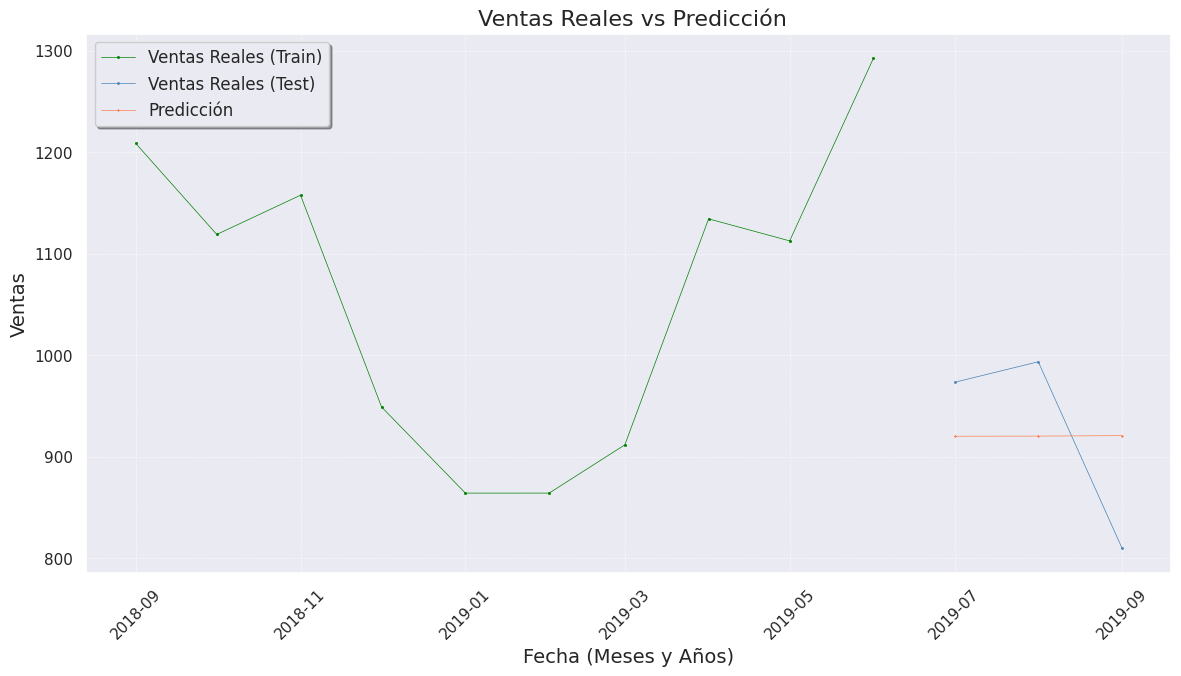

In [71]:
# Desescalar y_train si no lo has hecho antes
y_train_descaled = target_scaler.inverse_transform(y_train.reshape(-1, 1))

# Convertir `month+year` a datetime si es de tipo Period
total_sales_by_month['month+year'] = total_sales_by_month['month+year'].astype(str)
total_sales_by_month['month+year'] = pd.to_datetime(total_sales_by_month['month+year'])

# Obtener las fechas correspondientes a los datos de entrenamiento y prueba
train_dates = total_sales_by_month['month+year'][:len(y_train)].to_numpy()
test_dates = total_sales_by_month['month+year'][len(y_train):len(y_train) + len(y_test)].to_numpy()

# Crear la figura
plt.figure(figsize=(14, 7))

# Graficar las ventas reales de entrenamiento
plt.plot(train_dates, y_train_descaled, label='Ventas Reales (Train)',
         linestyle='-', marker='s', linewidth=0.5, color='green', markersize=1)

# Graficar las ventas reales de prueba
plt.plot(test_dates, y_test_descaled,  label='Ventas Reales (Test)',
         linestyle='-', marker='o', linewidth=0.5, color='steelblue', markersize=1)

# Graficar las predicciones
plt.plot(test_dates, predictions_descaled, label='Predicción',
         linestyle='-', marker='x', linewidth=0.5, color='coral', markersize=1)

# Configuración de títulos y etiquetas
plt.title(' Ventas Reales vs Predicción', fontsize=16)
plt.xlabel('Fecha (Meses y Años)', fontsize=14)
plt.ylabel('Ventas', fontsize=14)

# Formatear el eje X con fechas
plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad

# Leyenda con estilo mejorado
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

# Agregar cuadrícula con estilo más ligero
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Mostrar el gráfico
plt.show()
